In [1]:
import os, gc
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sps
import matplotlib.pyplot as plt
from os.path import join

import sys
sys.path.insert(0, '../..')

from spamosaic.framework import SpaMosaic

In [2]:
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.train_utils import set_seeds
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

# set_seeds(1234, dt=True)

In [3]:
data_dir = '/home/xuhua/xuhua_disco/gitrepo/BridgeNorm/SpaMosaic-release/data/integration/Mouse_brain_five_modalities'

ad1_rna = sc.read_h5ad(join(data_dir, 'slice1/s1_adata_rna.h5ad'))
ad1_h3k27me3 = sc.read_h5ad(join(data_dir, 'slice1/s1_adata_H3K27me3.h5ad'))
ad2_rna = sc.read_h5ad(join(data_dir, 'slice2/s2_adata_rna.h5ad'))
ad2_h3k4me3 = sc.read_h5ad(join(data_dir, 'slice2/s2_adata_H3K4me3.h5ad'))
ad3_rna = sc.read_h5ad(join(data_dir, 'slice3/s3_adata_rna.h5ad'))
ad3_h3k27ac = sc.read_h5ad(join(data_dir, 'slice3/s3_adata_H3K27ac.h5ad'))
ad4_rna = sc.read_h5ad(join(data_dir, 'slice4/s4_adata_rna.h5ad'))
ad4_atac = sc.read_h5ad(join(data_dir, 'slice4/s4_adata_atac.h5ad'))

### preprocessing

Preprocessing this dataset may take some time.

In [4]:
# input_dict = {
#     'rna':      [ad1_rna,      ad2_rna,     ad3_rna,    ad4_rna],
#     'H3K27me3': [ad1_h3k27me3, None,        None,        None],
#     'H3K4me3':  [None,         ad2_h3k4me3, None,        None],
#     'H3K27ac':  [None,         None,        ad3_h3k27ac, None],
#     'atac':     [None,         None,        None,        ad4_atac]
# }

# input_key = 'dimred_bc'

# RNA_preprocess(input_dict['rna'], batch_corr=True, n_hvg=5000, batch_key='src', key=input_key)
# Epigenome_preprocess(input_dict['H3K27me3'], batch_corr=False, n_peak=50000, batch_key='src', key=input_key)
# Epigenome_preprocess(input_dict['H3K4me3'], batch_corr=False, n_peak=50000, batch_key='src', key=input_key)
# Epigenome_preprocess(input_dict['H3K27ac'], batch_corr=False, n_peak=50000, batch_key='src', key=input_key)
# Epigenome_preprocess(input_dict['atac'], batch_corr=False, n_peak=50000, batch_key='src', key=input_key)

# np.save('./cache/ad1_rna_inp.npy', ad1_rna.obsm[input_key])
# np.save('./cache/ad2_rna_inp.npy', ad2_rna.obsm[input_key])
# np.save('./cache/ad3_rna_inp.npy', ad3_rna.obsm[input_key])
# np.save('./cache/ad4_rna_inp.npy', ad4_rna.obsm[input_key])
# np.save('./cache/ad1_h3k27me3_inp.npy', ad1_h3k27me3.obsm[input_key])
# np.save('./cache/ad2_h3k4me3_inp.npy', ad2_h3k4me3.obsm[input_key])
# np.save('./cache/ad3_h3k27ac_inp.npy', ad3_h3k27ac.obsm[input_key])
# np.save('./cache/ad4_atac_inp.npy', ad4_atac.obsm[input_key])

load the cached representations 

In [5]:
input_key = 'dimred_bc'
ad1_rna.obsm[input_key] = np.load('./cache/ad1_rna_inp.npy')
ad2_rna.obsm[input_key] = np.load('./cache/ad2_rna_inp.npy')
ad3_rna.obsm[input_key] = np.load('./cache/ad3_rna_inp.npy')
ad4_rna.obsm[input_key] = np.load('./cache/ad4_rna_inp.npy')
ad1_h3k27me3.obsm[input_key] = np.load('./cache/ad1_h3k27me3_inp.npy')
ad2_h3k4me3.obsm[input_key] = np.load('./cache/ad2_h3k4me3_inp.npy')
ad3_h3k27ac.obsm[input_key] = np.load('./cache/ad3_h3k27ac_inp.npy')
ad4_atac.obsm[input_key] = np.load('./cache/ad4_atac_inp.npy')

input_dict = {
    'rna':      [ad1_rna,      ad2_rna,     ad3_rna,    ad4_rna],
    'H3K27me3': [ad1_h3k27me3, None,        None,        None],
    'H3K4me3':  [None,         ad2_h3k4me3, None,        None],
    'H3K27ac':  [None,         None,        ad3_h3k27ac, None],
    'atac':     [None,         None,        None,        ad4_atac]
}


### training

In [6]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', intra_knn=10, inter_knn=10, w_g=0.8, 
    seed=1234, 
    device='cuda:0'
)

model.train(net='wlgcn', lr=0.01, T=0.01, n_epochs=100)

batch0: ['rna', 'H3K27me3']
batch1: ['rna', 'H3K4me3']
batch2: ['rna', 'H3K27ac']
batch3: ['rna', 'atac']
------Calculating spatial graph...
The graph contains 97520 edges, 9752 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 95480 edges, 9548 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 93700 edges, 9370 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 92150 edges, 9215 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 97520 edges, 9752 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 95480 edges, 9548 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 93700 edges, 9370 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 92150 edges, 9

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


In [7]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


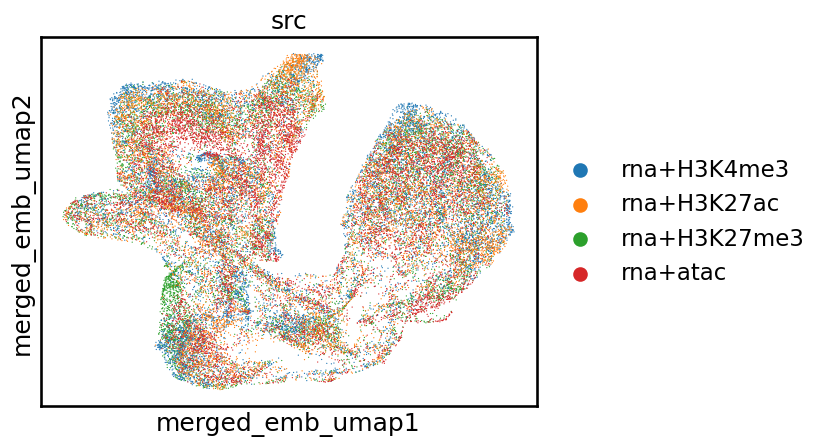

In [8]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

### clustering

In [9]:
utls.clustering(ad_mosaic, n_cluster=12, used_obsm='merged_emb', algo='mclust', key='mclust')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'mclust')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


fitting ...
  |======================================================================| 100%


In [10]:
utls.flip_axis(ad_embs, axis=0)
utls.flip_axis(ad_embs, axis=1)

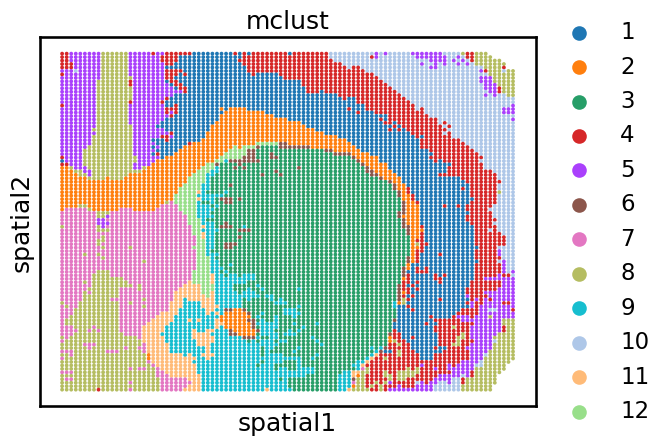

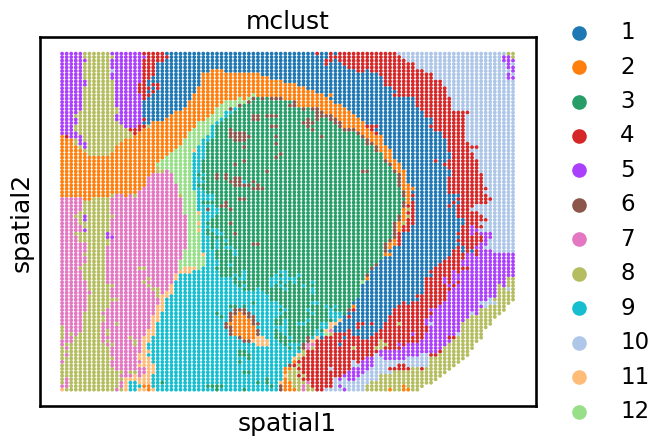

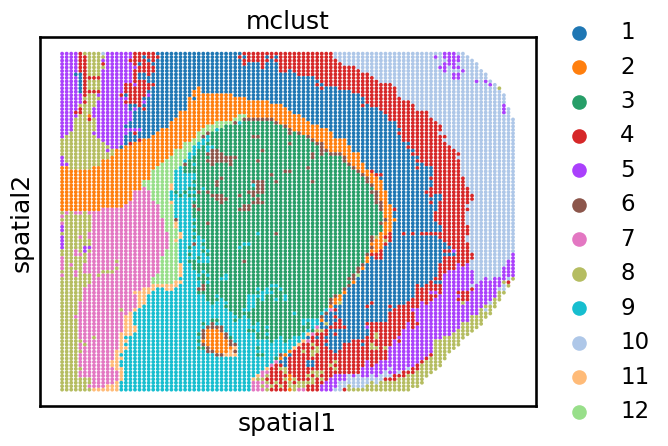

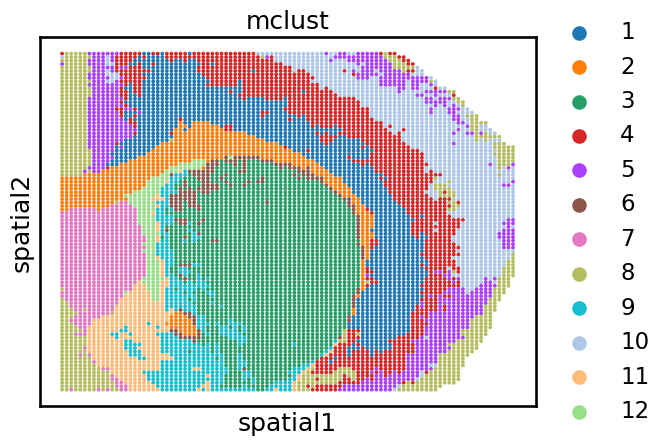

In [11]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'mclust', s=30)

### Imputation

Loading the precomputed gene activity scores (GAS)/chromatin silence scores (CSS) for each slice. We followed the [tutorial of Signac](https://stuartlab.org/signac/articles/overview) to convert the ATAC/histone modification data into GAS/CSS data. The precomputed GAS/CSS data can be downloaded from [google drive](https://drive.google.com/drive/folders/1NNP2tdVed4wB8Fmi8iZnLSX3IKcdc_KO?usp=drive_link).

<b>TODO</b>: Store the input modality assays in `.uns`, as `.layers` requires the data dimensions to match with `.X`.

In [12]:
tmp_out_dir = '/home/xuhua/xuhua_disco/data/real_mosaic_cases/mouse_brain_rna+atac+histone/intermediate_output_ads/tmp_folder'

ad1_gs = sc.read_h5ad(join(tmp_out_dir, 'k27me3_gam.h5ad'))[ad1_rna.obs_names].copy()
ad2_gs = sc.read_h5ad(join(tmp_out_dir, 'k4me3_gam.h5ad'))[ad2_rna.obs_names].copy()
ad3_gs = sc.read_h5ad(join(tmp_out_dir, 'k27ac_gam.h5ad'))[ad3_rna.obs_names].copy()
ad4_gs = sc.read_h5ad(join(tmp_out_dir, 'atac_gam.h5ad'))[ad4_rna.obs_names].copy()

ad1_gs.obsm['emb'] = ad1_h3k27me3.obsm['emb'].copy()
ad2_gs.obsm['emb'] = ad2_h3k4me3.obsm['emb'].copy()
ad3_gs.obsm['emb'] = ad3_h3k27ac.obsm['emb'].copy()
ad4_gs.obsm['emb'] = ad4_atac.obsm['emb'].copy()

ad1_gs.layers['counts'] = sps.csr_matrix(ad1_gs.layers['raw'])
ad2_gs.layers['counts'] = sps.csr_matrix(ad2_gs.layers['raw'])
ad3_gs.layers['counts'] = sps.csr_matrix(ad3_gs.layers['raw'])
ad4_gs.layers['counts'] = sps.csr_matrix(ad4_gs.layers['raw'])

ad1_gs.obs['mclust'] = ad1_rna.obs['mclust'] = ad_embs[0].obs['mclust'].to_list()
ad2_gs.obs['mclust'] = ad2_rna.obs['mclust'] = ad_embs[1].obs['mclust'].to_list()
ad3_gs.obs['mclust'] = ad3_rna.obs['mclust'] = ad_embs[2].obs['mclust'].to_list()
ad4_gs.obs['mclust'] = ad4_rna.obs['mclust'] = ad_embs[3].obs['mclust'].to_list()

In [13]:
shared_rna = ad1_rna.var_names.intersection(ad2_rna.var_names).intersection(ad3_rna.var_names).intersection(ad4_rna.var_names)

ad1_rna = ad1_rna[:, shared_rna].copy()
ad2_rna = ad2_rna[:, shared_rna].copy()
ad3_rna = ad3_rna[:, shared_rna].copy()
ad4_rna = ad4_rna[:, shared_rna].copy()

In [14]:
imp_input_dict = {
     'rna':     [ad1_rna, ad2_rna, ad3_rna, ad4_rna],
     'H3K27me3':[ad1_gs,  None,    None,    None],
     'H3K4me3': [None,    ad2_gs,  None,    None],
     'H3K27ac': [None,    None,    ad3_gs,  None],
     'atac':    [None,    None,    None,    ad4_gs]
}

In [15]:
def impute_memEff(modBatch_dict, emb_key='emb', layer_key='counts', imp_knn=10):
    mods = list(modBatch_dict.keys())
    n_batches = len(modBatch_dict[mods[0]])
    imputed_batchDict = {
        k: [None]*n_batches
        for k in modBatch_dict.keys()
    }

    for k in modBatch_dict.keys():
        aligned_mod_pool = np.vstack([ad.obsm[emb_key] for ad in modBatch_dict[k] if ad is not None])
        target_mod_pool = np.vstack(
            [ad.layers[layer_key].A if sps.issparse(ad.layers[layer_key]) else ad.layers[layer_key]
            for ad in modBatch_dict[k] if ad is not None]
        )
        for bi in range(n_batches):
            bi_measued_mod_names = [_ for _ in modBatch_dict.keys() if modBatch_dict[_][bi] is not None]
            # already measured, skip
            if k in bi_measued_mod_names: continue

            n_obs = modBatch_dict[bi_measued_mod_names[0]][bi].n_obs
            print(f'impute {k}-{layer_key} for batch-{bi+1}')

            imps = np.zeros((n_obs, target_mod_pool.shape[1]))
            for k_v in bi_measued_mod_names:
                knn_ind = utls.nn_approx(modBatch_dict[k_v][bi].obsm[emb_key], aligned_mod_pool, knn=imp_knn)
                p_q = target_mod_pool[knn_ind.ravel()].reshape(*(knn_ind.shape), target_mod_pool.shape[1])
                imps += np.mean(p_q, axis=1)
            imputed_batchDict[k][bi] = imps/len(bi_measued_mod_names)

            del knn_ind, p_q, imps
            gc.collect()
        del aligned_mod_pool, target_mod_pool
        gc.collect()
            
    return imputed_batchDict


In [16]:
# imputed_gene_assays = model.impute(imp_input_dict, emb_key='emb', layer_key='counts', imp_knn=10)
imputed_gene_assays = impute_memEff(imp_input_dict, emb_key='emb', layer_key='counts', imp_knn=10)

impute H3K27me3-counts for batch-2
impute H3K27me3-counts for batch-3
impute H3K27me3-counts for batch-4
impute H3K4me3-counts for batch-1
impute H3K4me3-counts for batch-3
impute H3K4me3-counts for batch-4
impute H3K27ac-counts for batch-1
impute H3K27ac-counts for batch-2
impute H3K27ac-counts for batch-4
impute atac-counts for batch-1
impute atac-counts for batch-2
impute atac-counts for batch-3


In [17]:
def array2ann(imp_X, var_names, row_meta, spatial_xy):
    ad = sc.AnnData(imp_X, obs=row_meta.copy())
    ad.layers['counts'] = imp_X.copy()
    ad.var_names = var_names
    ad.obsm['spatial'] = spatial_xy
    return ad

In [18]:
ad1_imp_h3k4me3_gs = array2ann(imputed_gene_assays['H3K4me3'][0], ad2_gs.var_names, ad_embs[0].obs, ad_embs[0].obsm['spatial'])
ad1_imp_h3k27ac_gs = array2ann(imputed_gene_assays['H3K27ac'][0], ad3_gs.var_names, ad_embs[0].obs, ad_embs[0].obsm['spatial'])
ad1_imp_atac_gs    = array2ann(imputed_gene_assays['atac'][0], ad4_gs.var_names, ad_embs[0].obs, ad_embs[0].obsm['spatial'])

ad2_imp_h3k27me3_gs = array2ann(imputed_gene_assays['H3K27me3'][1], ad1_gs.var_names, ad_embs[1].obs, ad_embs[1].obsm['spatial'])
ad2_imp_h3k27ac_gs  = array2ann(imputed_gene_assays['H3K27ac'][1], ad3_gs.var_names, ad_embs[1].obs, ad_embs[1].obsm['spatial'])
ad2_imp_atac_gs     = array2ann(imputed_gene_assays['atac'][1], ad4_gs.var_names, ad_embs[1].obs, ad_embs[1].obsm['spatial'])

ad3_imp_h3k27me3_gs = array2ann(imputed_gene_assays['H3K27me3'][2], ad1_gs.var_names, ad_embs[2].obs, ad_embs[2].obsm['spatial'])
ad3_imp_h3k4me3_gs  = array2ann(imputed_gene_assays['H3K4me3'][2], ad2_gs.var_names, ad_embs[2].obs, ad_embs[2].obsm['spatial'])
ad3_imp_atac_gs     = array2ann(imputed_gene_assays['atac'][2], ad4_gs.var_names, ad_embs[2].obs, ad_embs[2].obsm['spatial'])

ad4_imp_h3k27me3_gs = array2ann(imputed_gene_assays['H3K27me3'][3], ad1_gs.var_names, ad_embs[3].obs, ad_embs[3].obsm['spatial'])
ad4_imp_h3k4me3_gs  = array2ann(imputed_gene_assays['H3K4me3'][3], ad2_gs.var_names, ad_embs[3].obs, ad_embs[3].obsm['spatial'])
ad4_imp_h3k27ac_gs  = array2ann(imputed_gene_assays['H3K27ac'][3], ad3_gs.var_names, ad_embs[3].obs, ad_embs[3].obsm['spatial'])

### DEG analysis

In [19]:
def find_DEG(ad, clust_key='mclust'):
    ad.X = ad.layers['counts'].copy()
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)
    sc.tl.rank_genes_groups(ad, clust_key, method="wilcoxon")
    return ad

def get_clust_marker(ad, clust):
    rank_names = ad.uns['rank_genes_groups']['names']
    rank_logfc = ad.uns['rank_genes_groups']['logfoldchanges']
    rank_pval  = ad.uns['rank_genes_groups']['pvals']
    rank_pval_adj  = ad.uns['rank_genes_groups']['pvals_adj']
    
    df_rank_scpy = pd.DataFrame(rank_logfc[clust].reshape(-1, 1), index=rank_names[clust], columns=['logfc'])
    df_rank_scpy['pval'] = rank_pval[clust]
    df_rank_scpy['pval_adj'] = rank_pval_adj[clust]
    return df_rank_scpy

def RNA_GS_relation_scatter(df_rna, df_gam, adj_pval_thr=0.1, logfc_cutoff=0.1, ax=None, s=40, show=True):
    df_rna_new = df_rna.loc[df_rna.pval_adj<=adj_pval_thr].copy()
    df_gam_new = df_gam.loc[df_gam.pval_adj<=adj_pval_thr].copy()
    df_rna_new = df_rna_new.loc[df_rna_new.logfc.abs() > logfc_cutoff].copy()
    df_gam_new = df_gam_new.loc[df_gam_new.logfc.abs() > logfc_cutoff].copy()
    
    shared_gene = df_rna_new.index.intersection(df_gam_new.index)
    df_rna_new = df_rna_new.loc[shared_gene].copy()
    df_gam_new = df_gam_new.loc[shared_gene].copy()

    x = df_rna_new.loc[shared_gene, 'logfc']
    y = df_gam_new.loc[shared_gene, 'logfc']
    if show:
        if ax is None:
            plt.scatter(x, y, s=s)
            ax = plt.gca()
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.show()
        else:
            ax.scatter(x, y, s=s)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
    return x, y

def get_quadrant_genes(x, y, area=1):
    if area == 1:
        return x.index[(x>0) & (y>0)]
    elif area == 2:
        return x.index[(x<0) & (y>0)]
    elif area == 3:
        return x.index[(x<0) & (y<0)]
    else:
        return x.index[(x>0) & (y<0)]

from upsetplot import UpSet
def ref_qry_upsetplot(ref_gene, qry_genes, ref_name, qry_names, save_path=None):
    # make a data frame for each set
    ref_df = pd.DataFrame({ref_name: True, 'Name': ref_gene})
    qry_dfs = [
        pd.DataFrame({name:True, 'Name': gs})
        for name, gs in zip(qry_names, qry_genes)
    ]
   
    # Merge three data frames together
    df = ref_df.copy()
    for x in qry_dfs:
        df = df.merge(x, on = 'Name', how = 'outer')
    
    # Replace NaN with False
    df = df.fillna(False)
    
    # Make sets index for the data frame
    df = df.set_index([ref_name] + qry_names)
    df = df.sort_index(level=0)

    plt.rcParams['font.family'] = 'Arial'
    upset = UpSet(df, subset_size='count', sort_categories_by='input')
    upset.plot()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()

def create_lightmap():
    from matplotlib.colors import LinearSegmentedColormap
    colors = ["blue", "cyan", "yellow", "red"]  # Red to yellow to cyan to blue
    n_bins = 10000  # Increase this number for a smoother transition
    cmap_name = "custom_colormap"
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return custom_cmap
    
def create_darkmap():
    from matplotlib.colors import LinearSegmentedColormap
    colors = ["darkblue", "deepskyblue", "orange", "darkred"] 
    n_bins = 100 
    cmap_name = "intense_custom_colormap"
    intense_custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return intense_custom_cmap

def list_minus(l1, l2):
    return list(set(l1) - set(l2))

def list_inter(l1, l2):
    return list(set(l1) & set(l2))

Find DEGs for different gene assays

In [20]:
rna_ads      = [ad1_rna,            ad2_rna,             ad3_rna,             ad4_rna]
h3k27me3_ads = [ad1_gs,             ad2_imp_h3k27me3_gs, ad3_imp_h3k27me3_gs, ad4_imp_h3k27me3_gs]
h3k4me3_ads  = [ad1_imp_h3k4me3_gs, ad2_gs,              ad3_imp_h3k4me3_gs,  ad4_imp_h3k4me3_gs]
h3k27ac_ads  = [ad1_imp_h3k27ac_gs, ad2_imp_h3k27ac_gs,  ad3_gs,              ad4_imp_h3k27ac_gs]
atac_ads     = [ad1_imp_atac_gs,    ad2_imp_atac_gs,     ad3_imp_atac_gs,     ad4_gs]

for ads in [rna_ads, h3k27me3_ads, h3k4me3_ads, h3k27ac_ads, atac_ads]:
    for ad in ads:
        ad = find_DEG(ad, clust_key='mclust')

Scatter plot of regions-specific gene relation between RNA and measured (or imputed) GAS/CSS  

======> 1


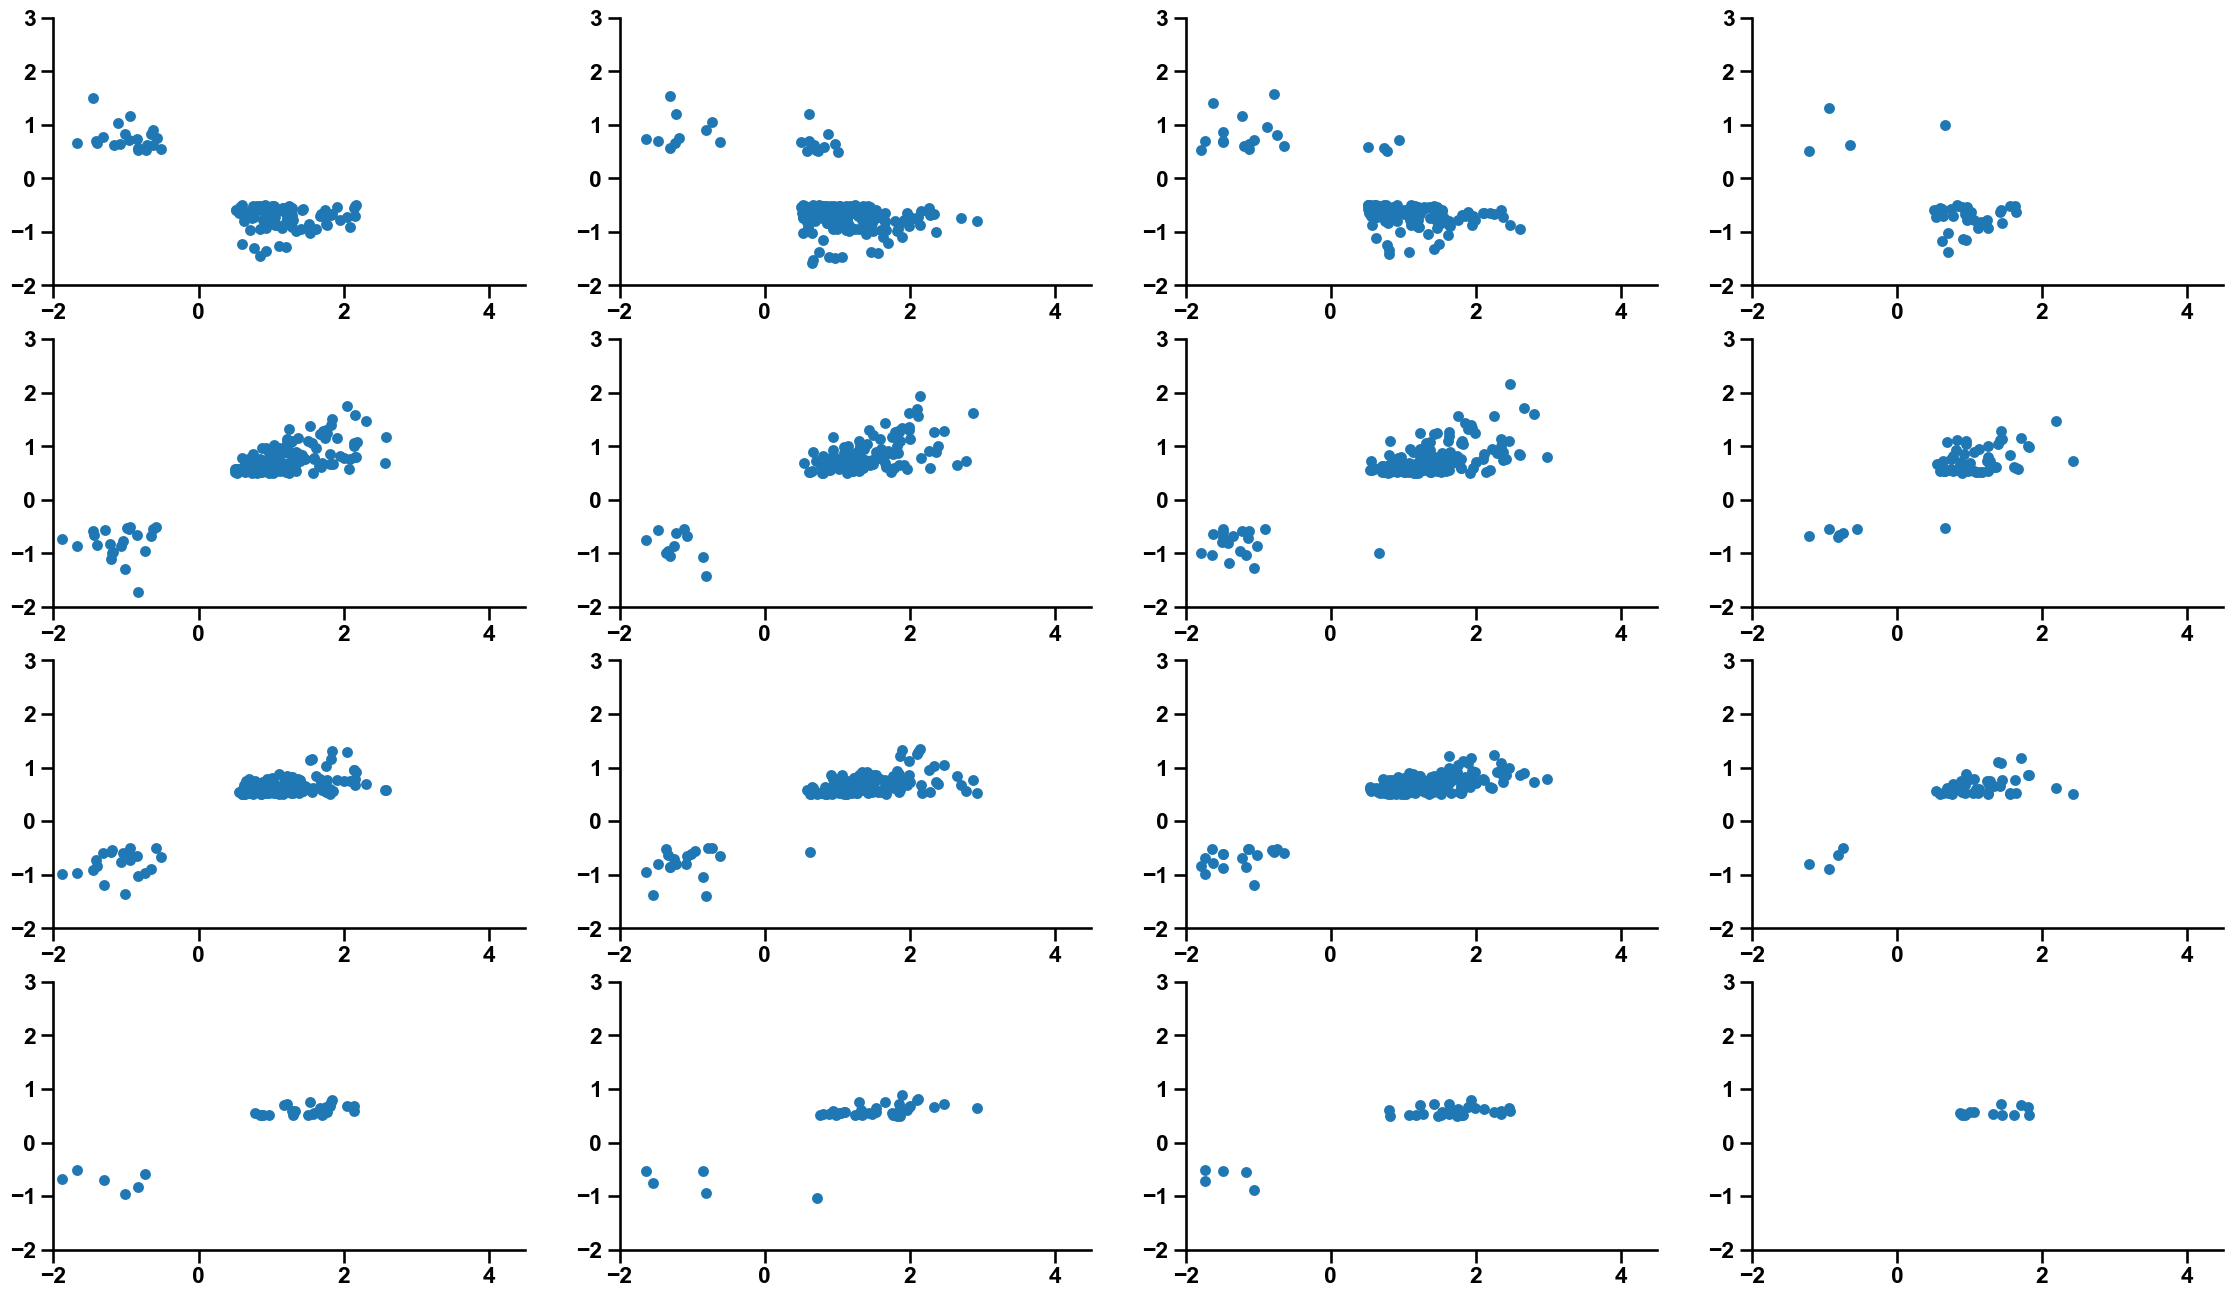

======> 2


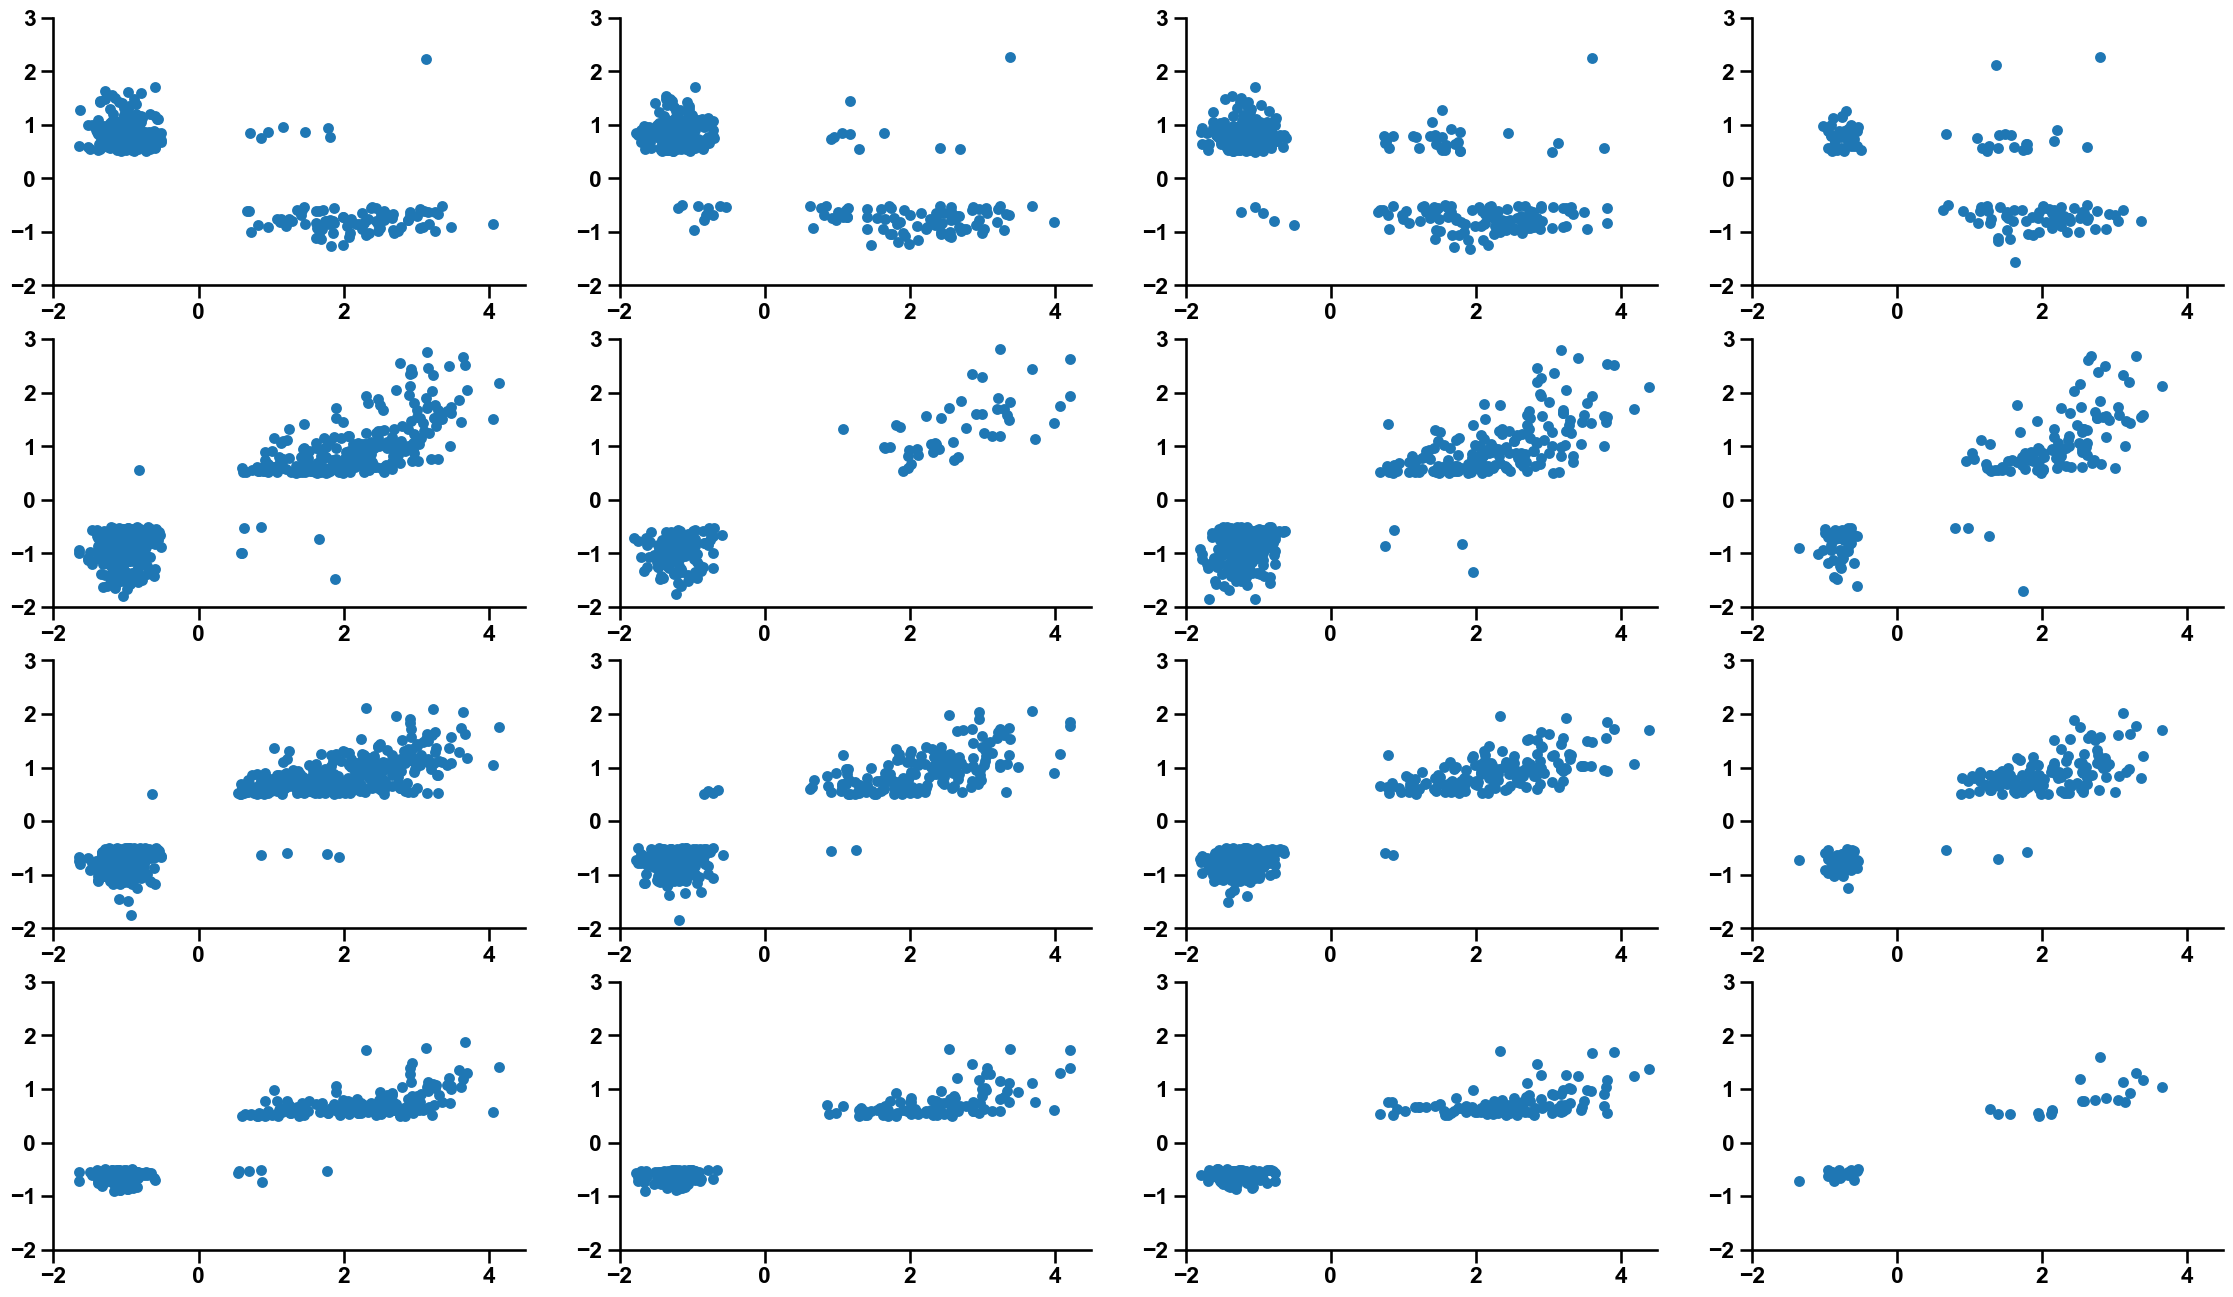

======> 3


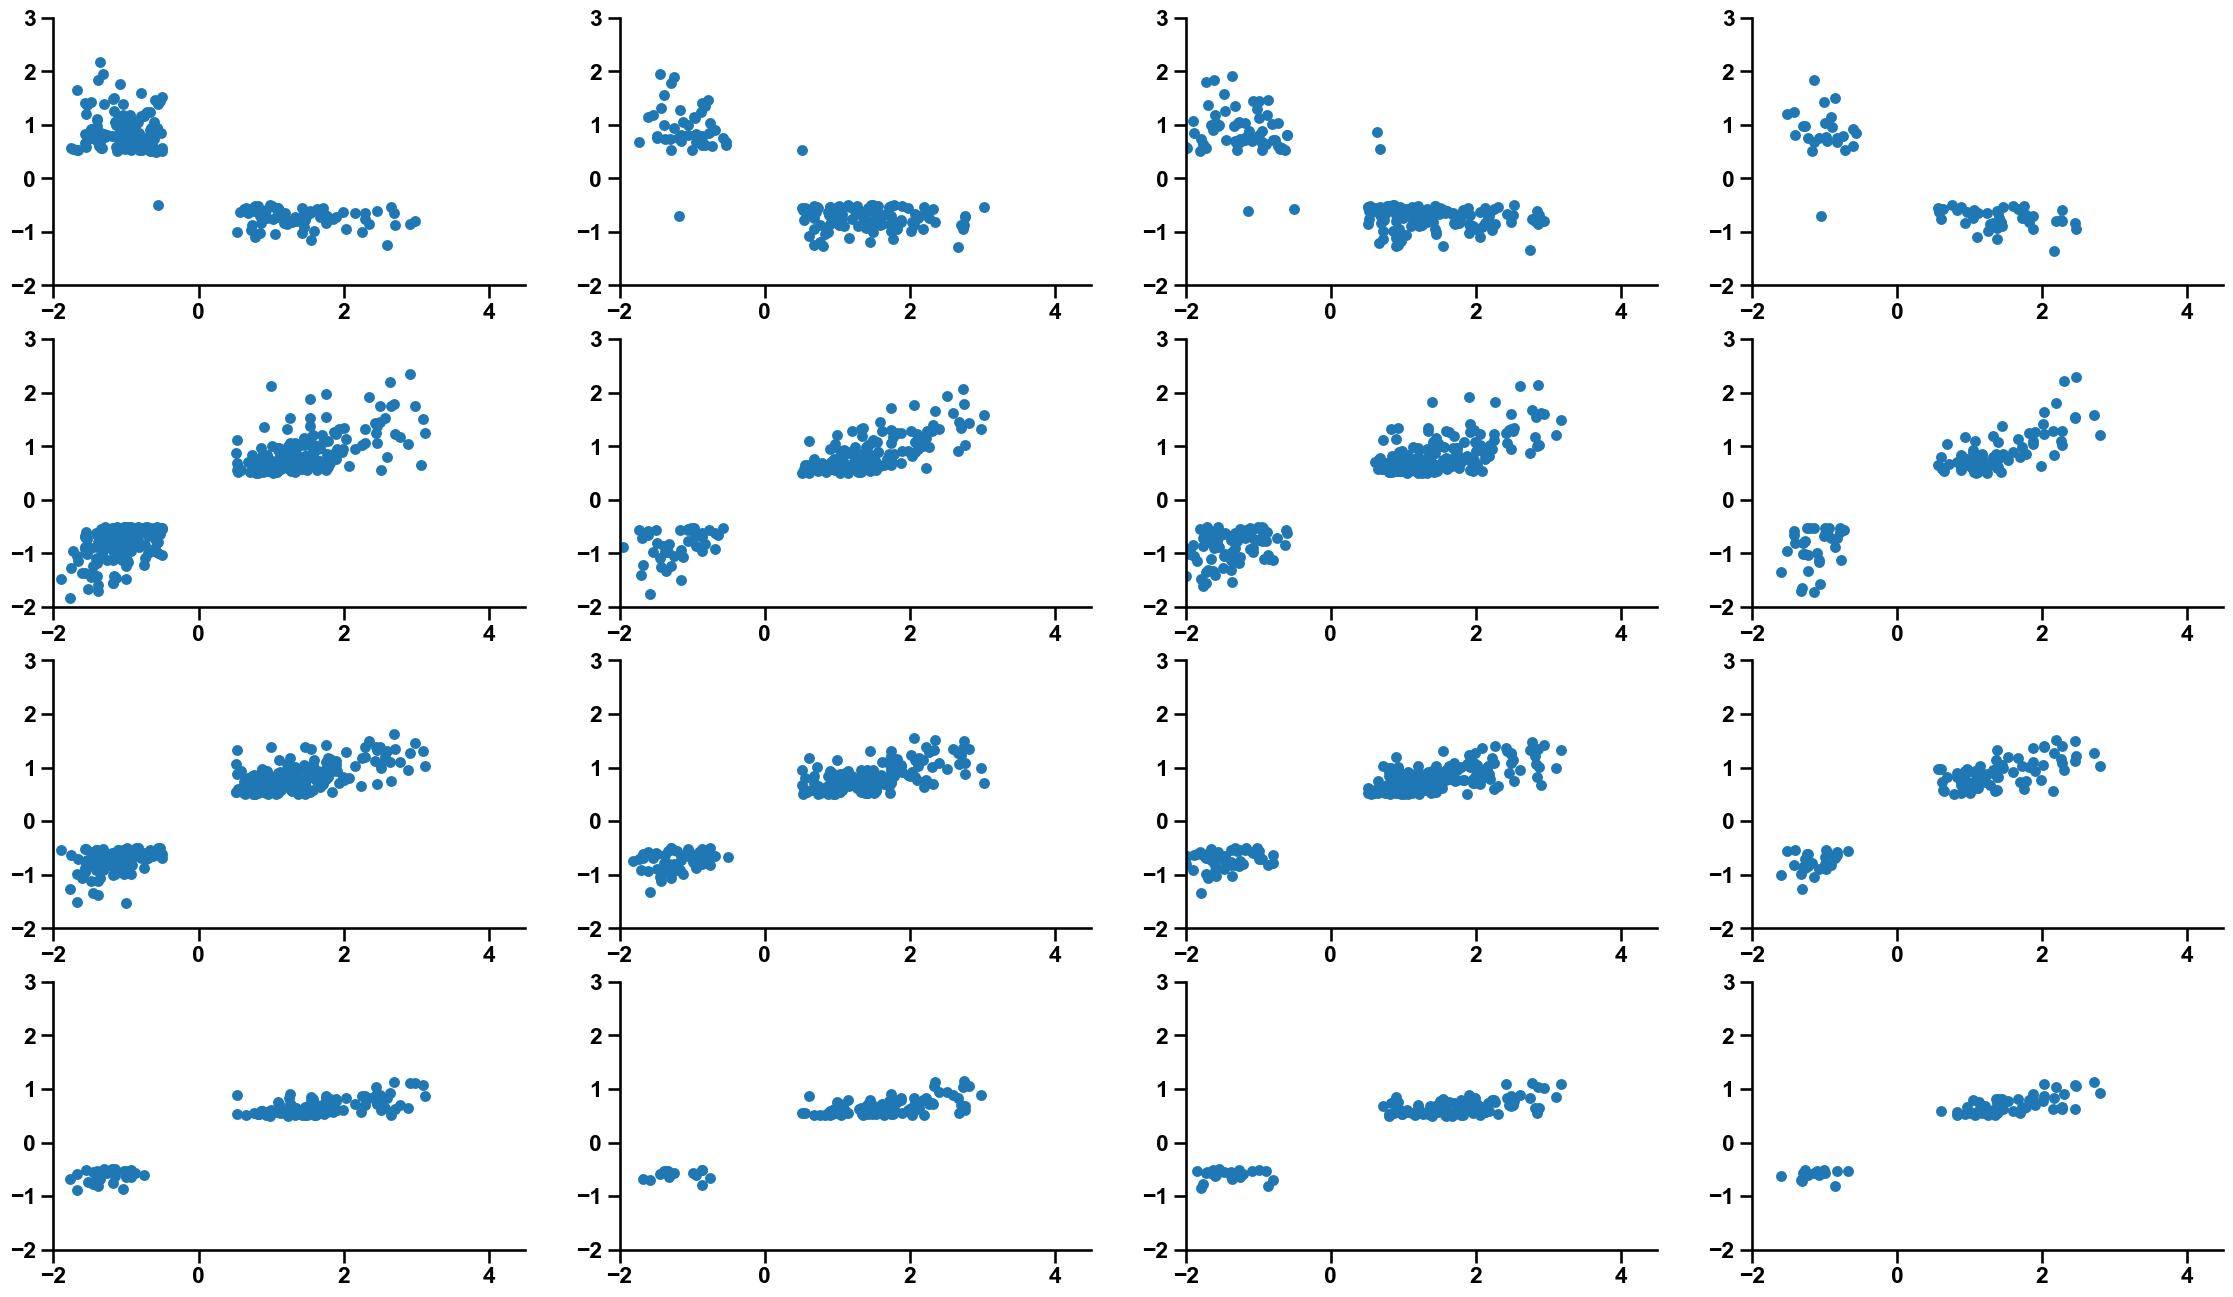

======> 4


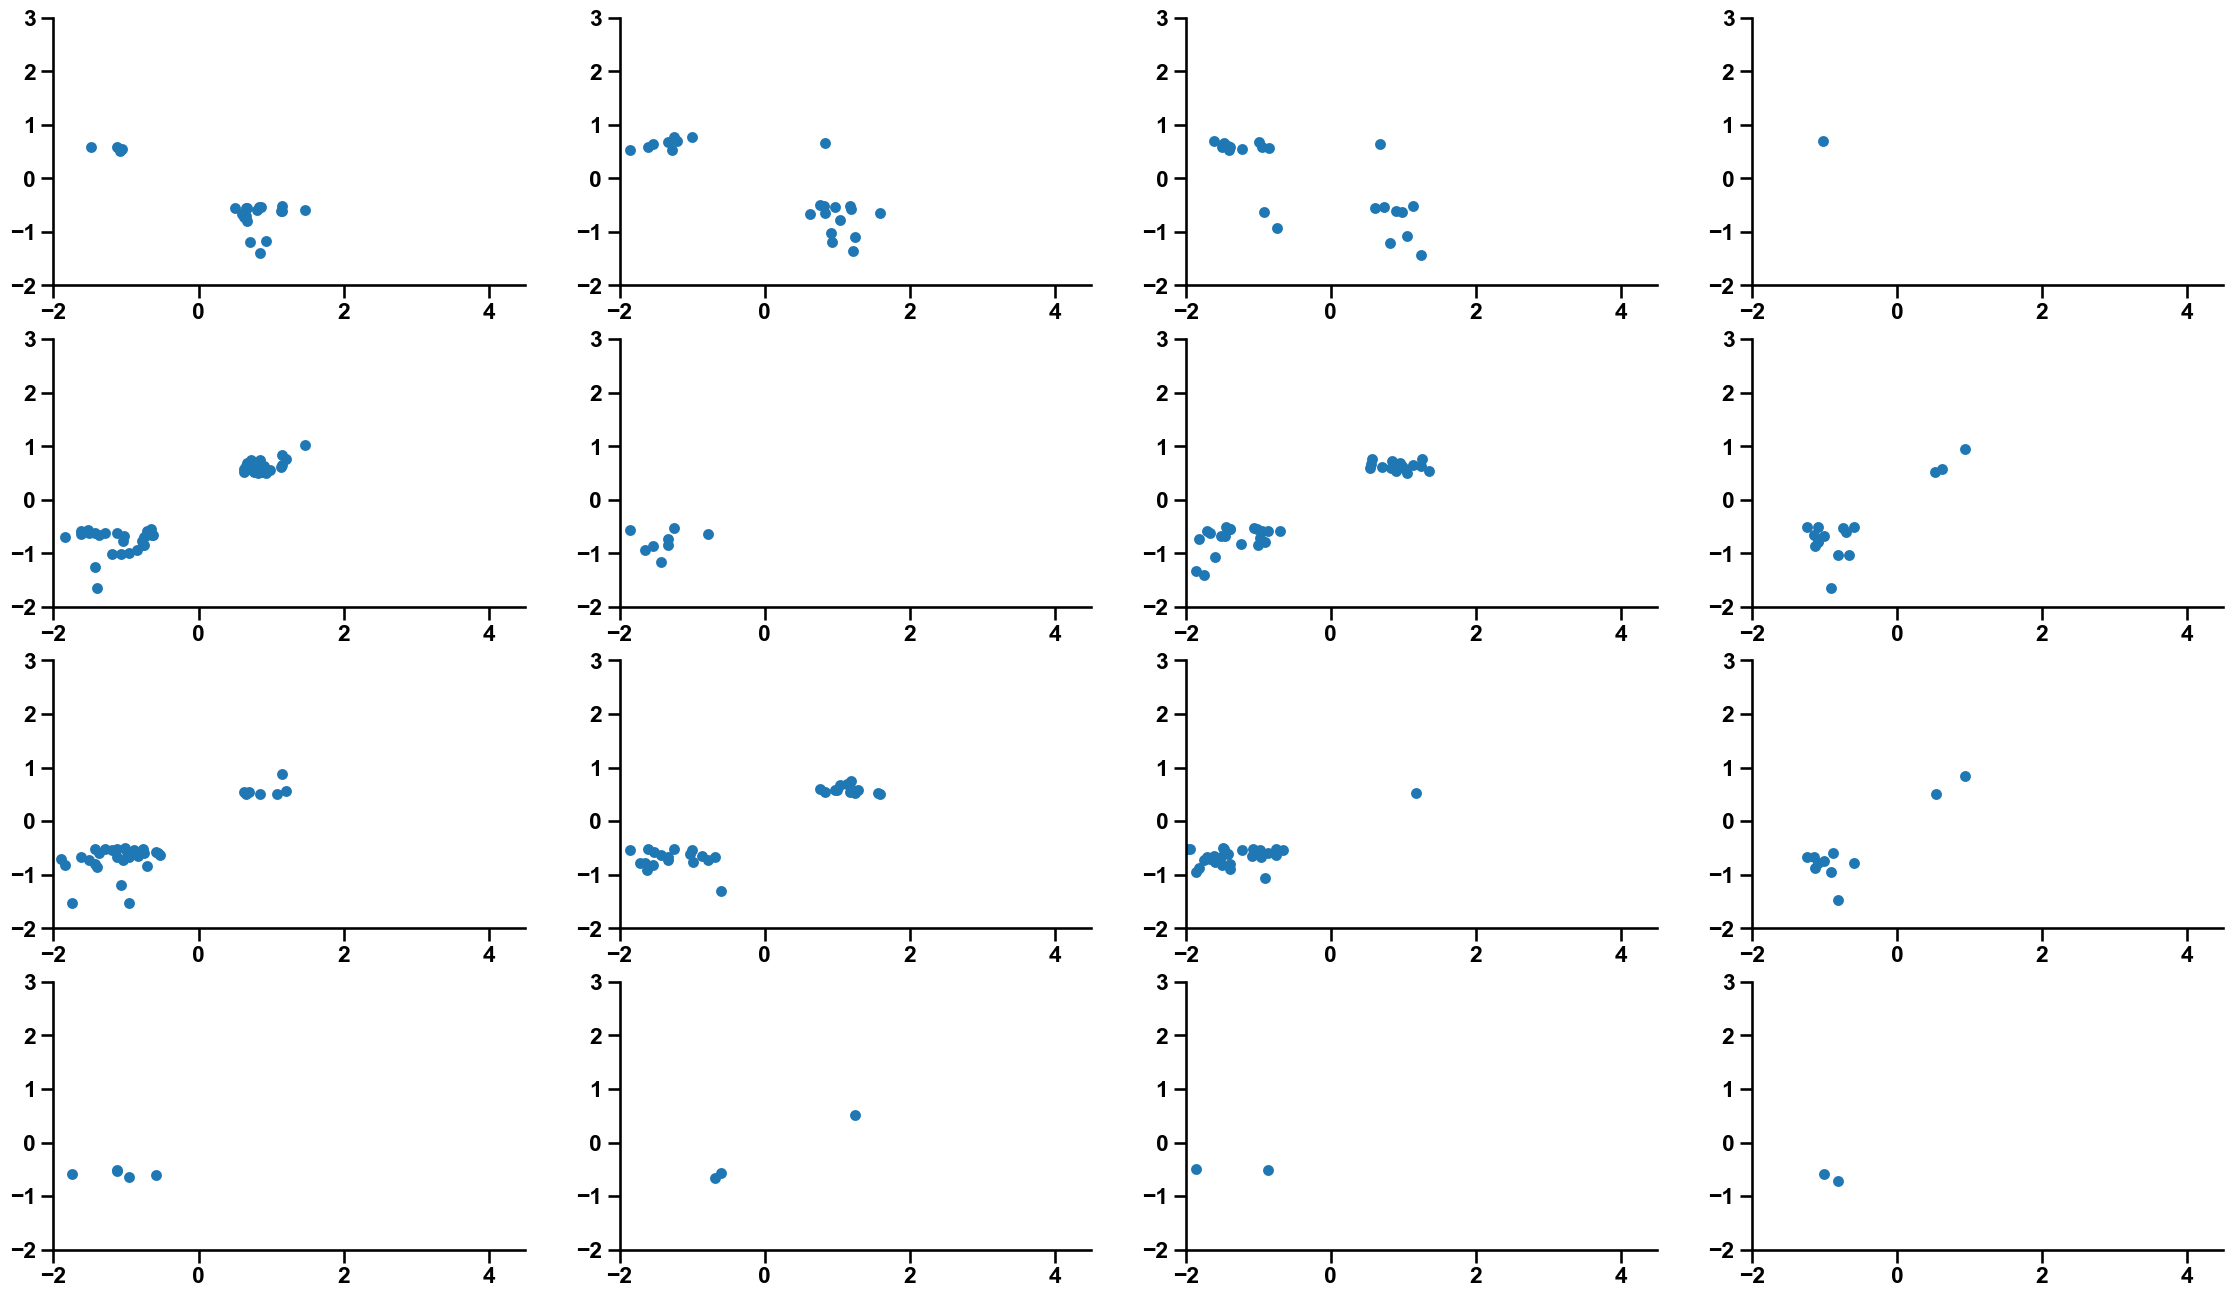

======> 5


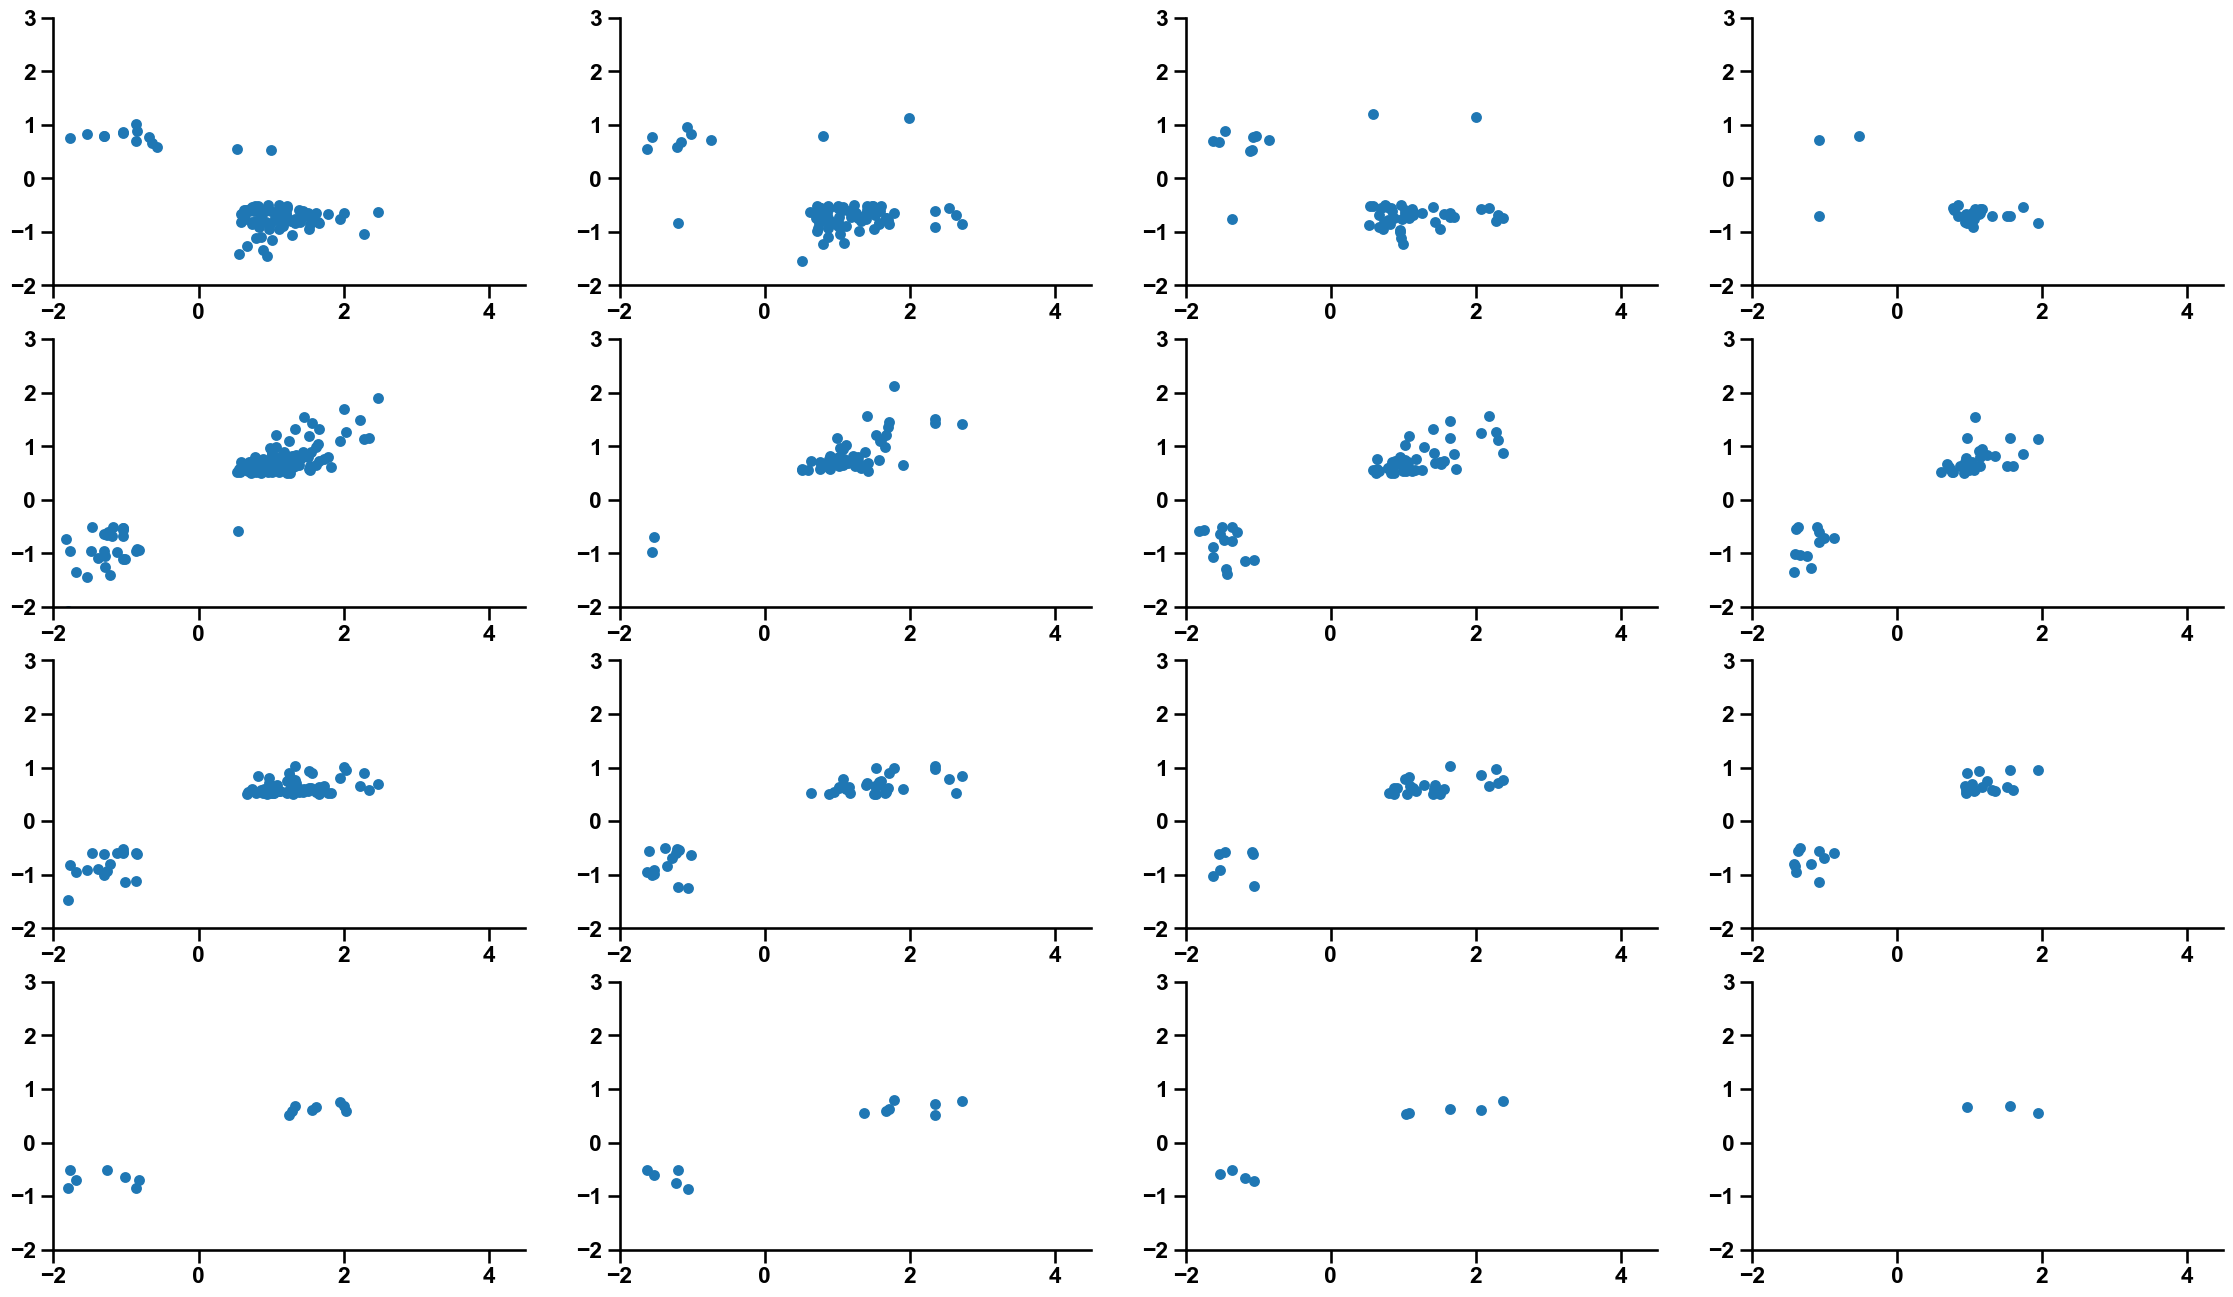

======> 6


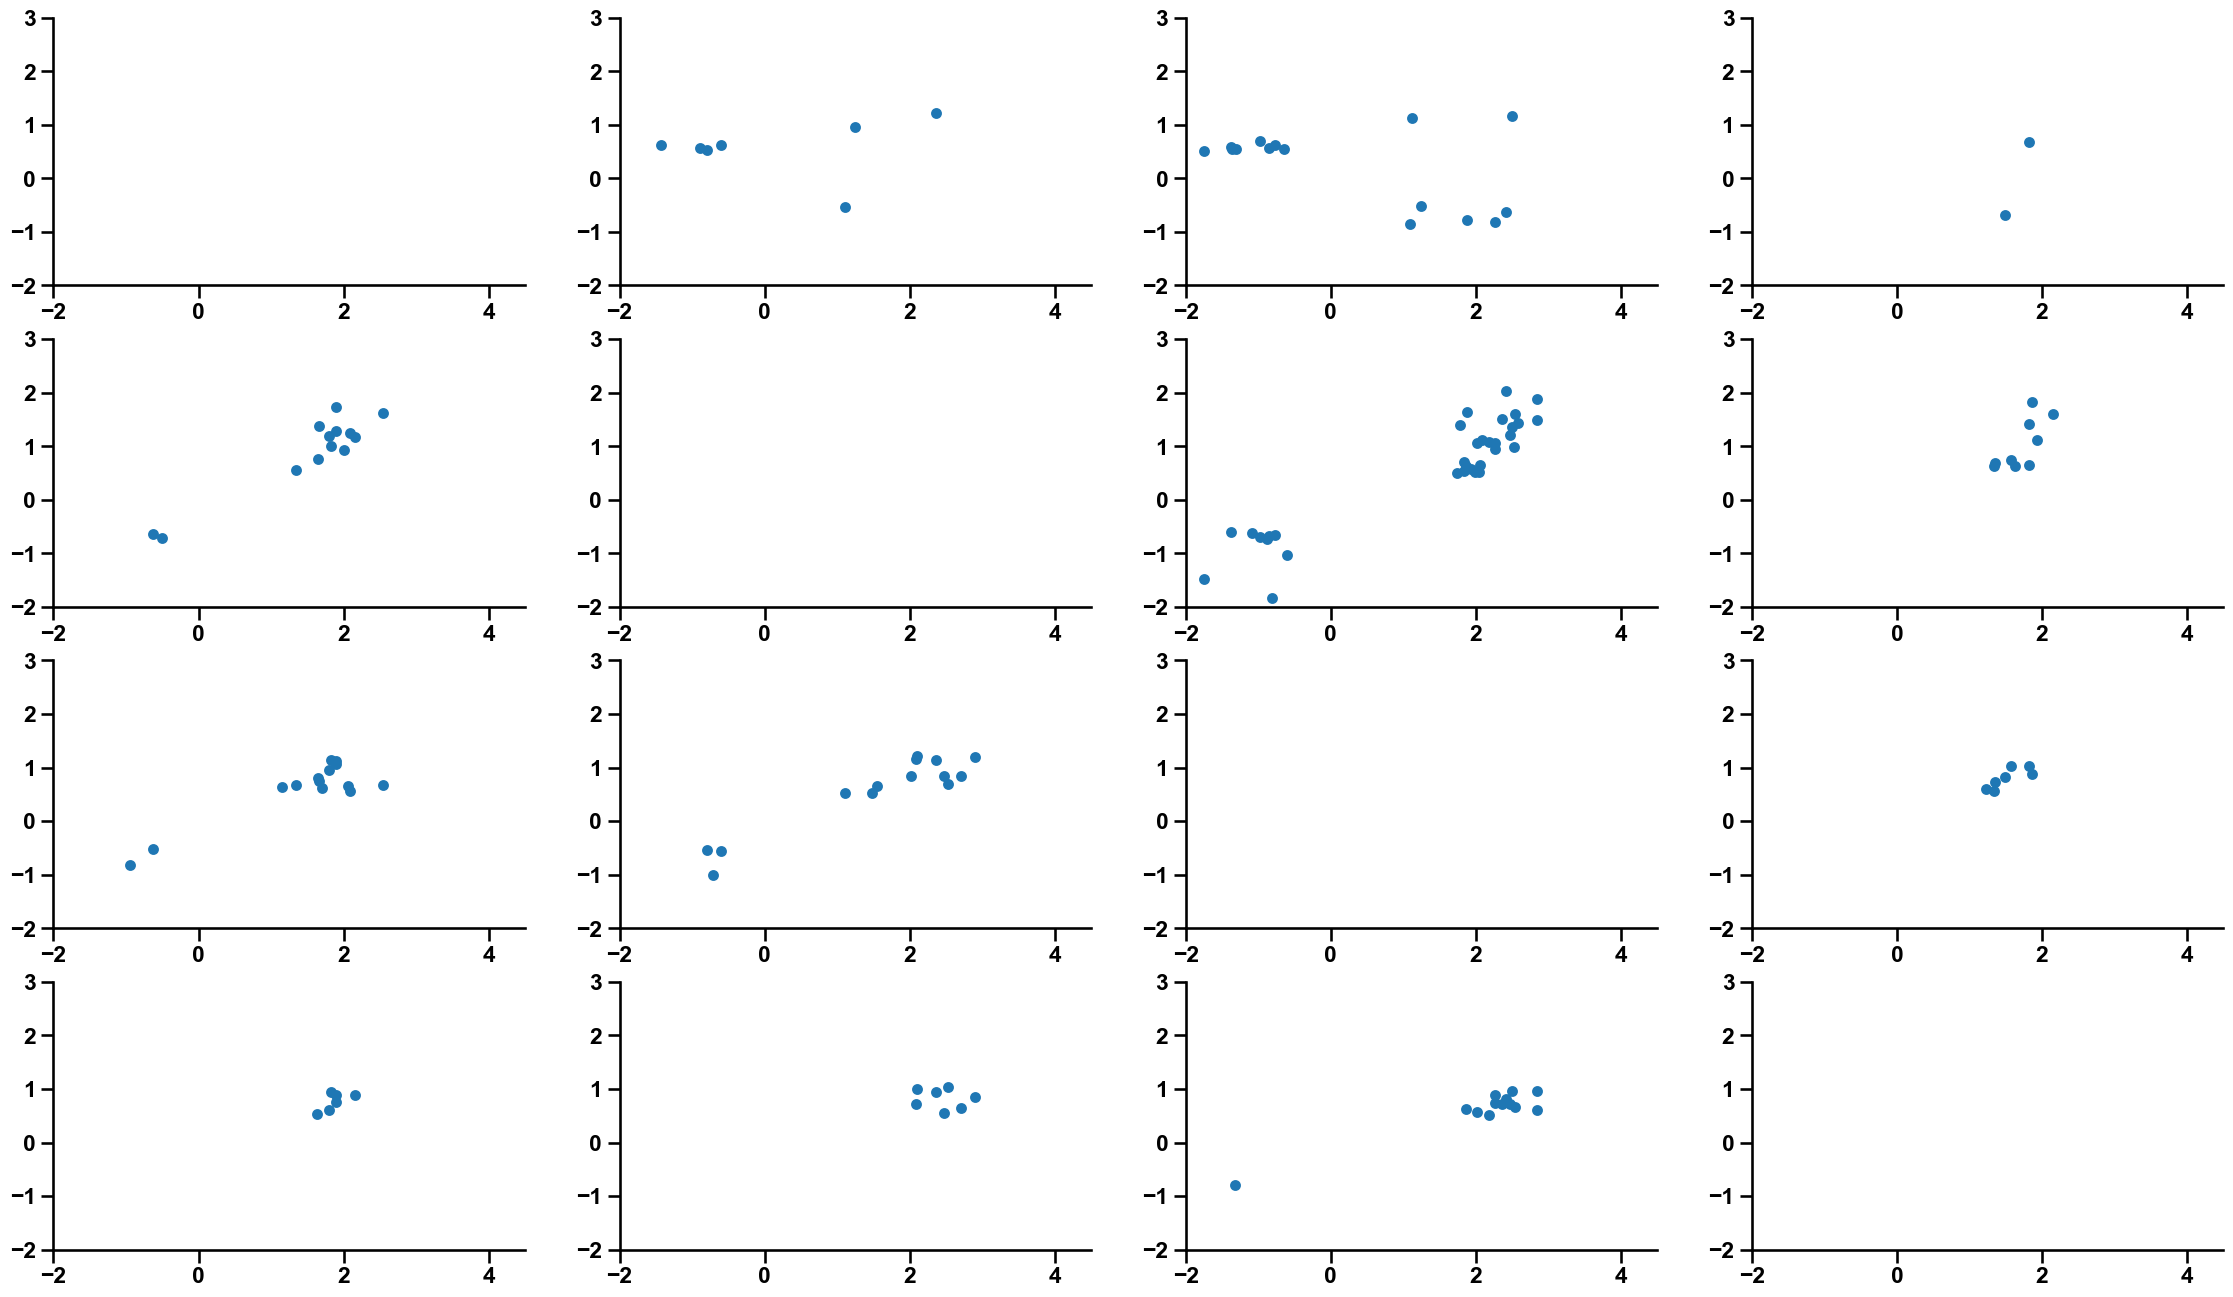

======> 7


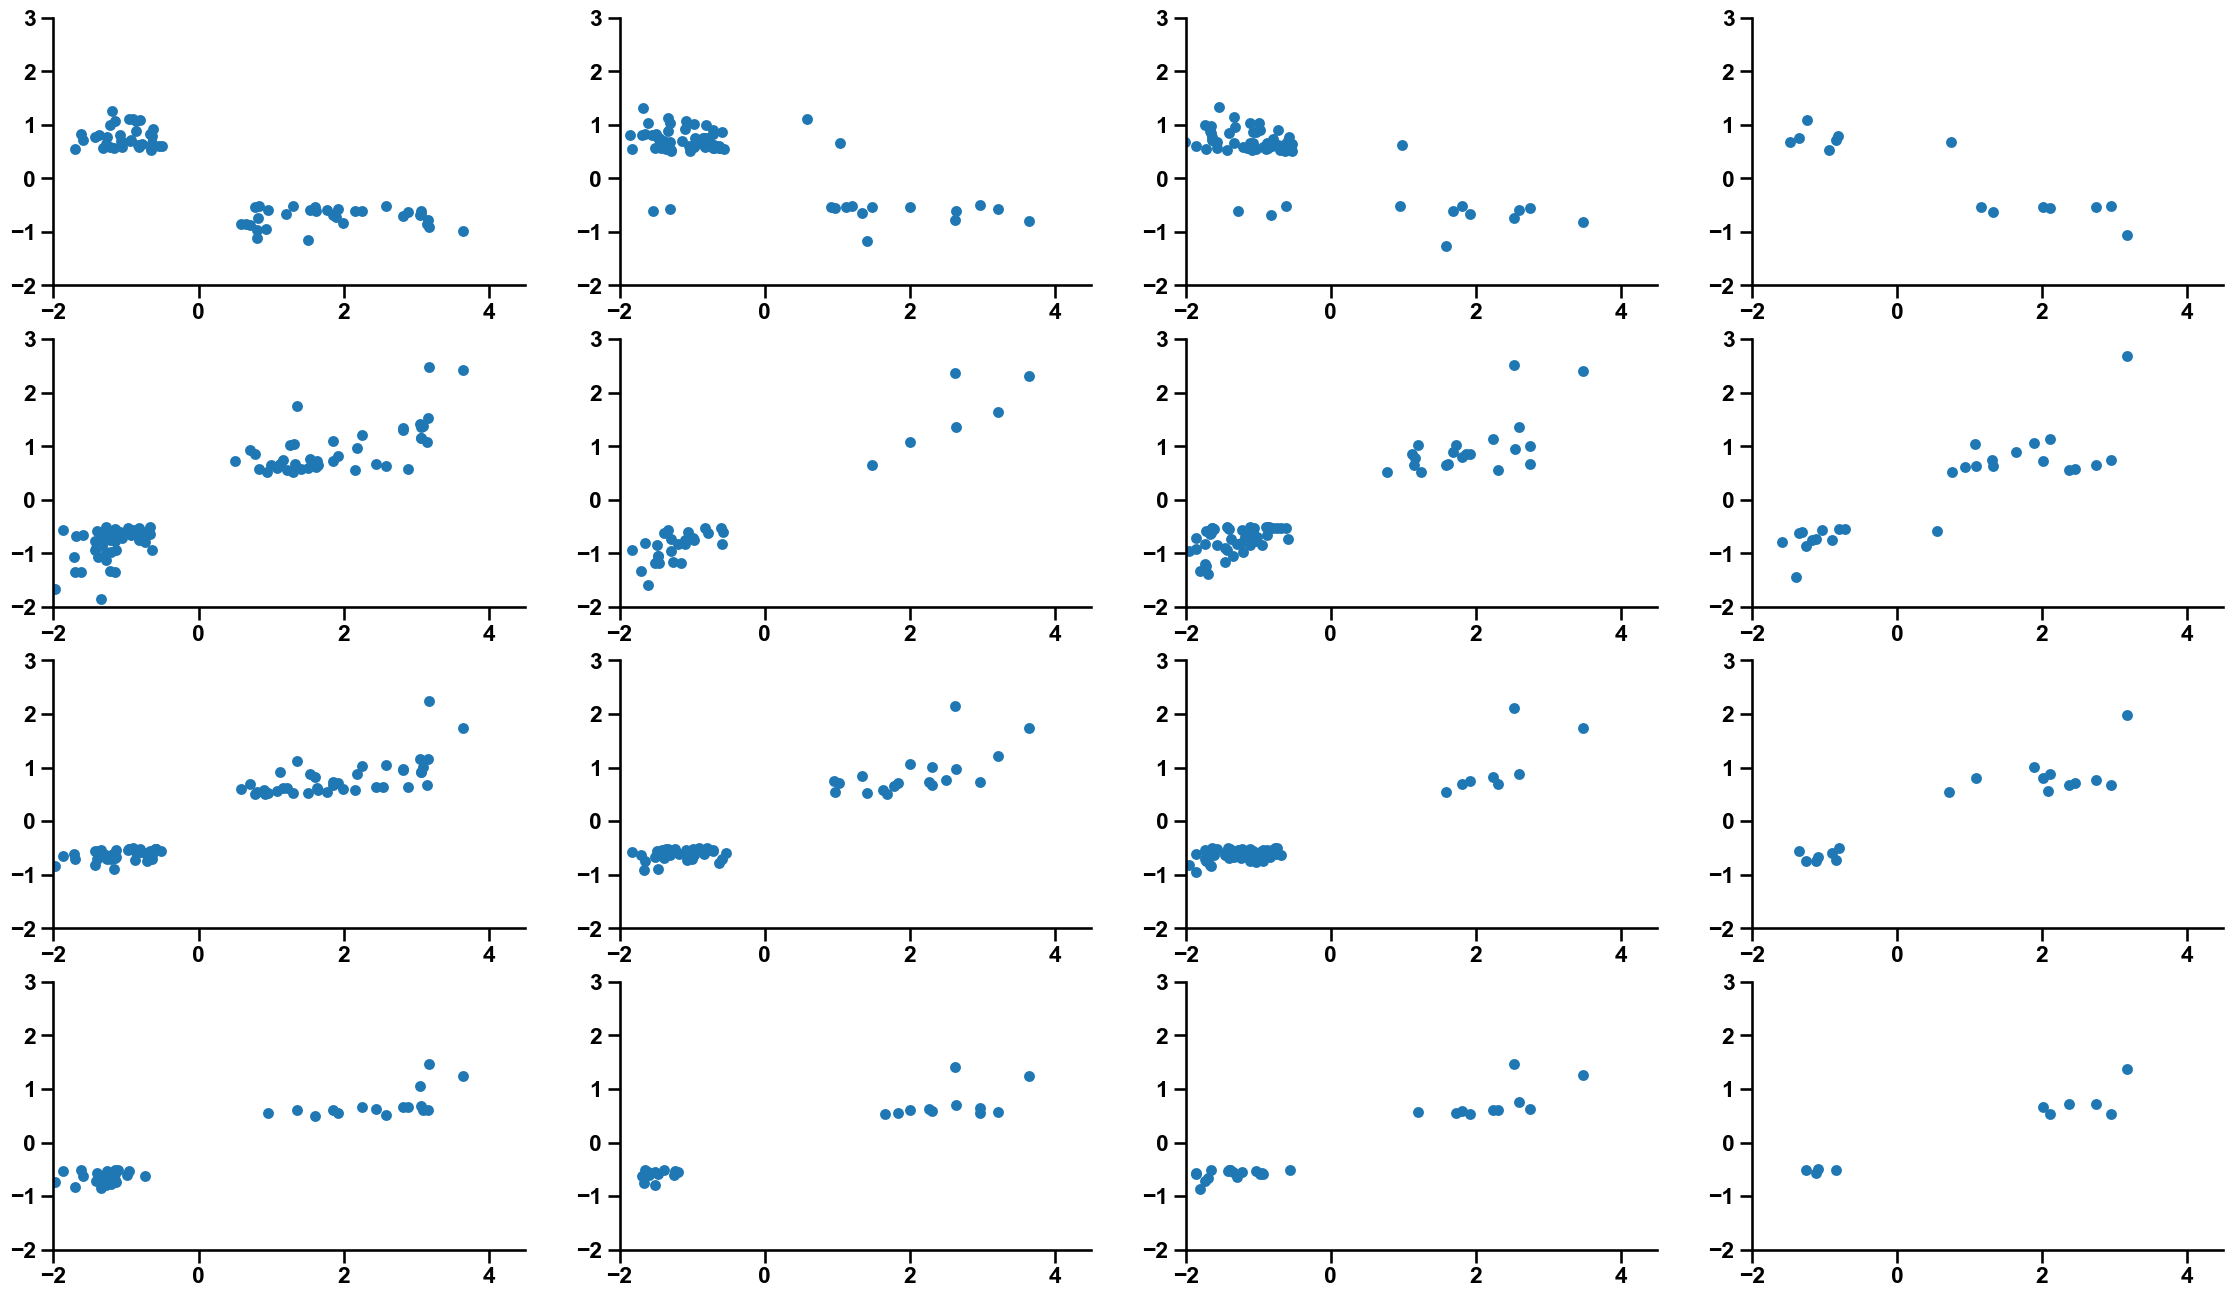

======> 8


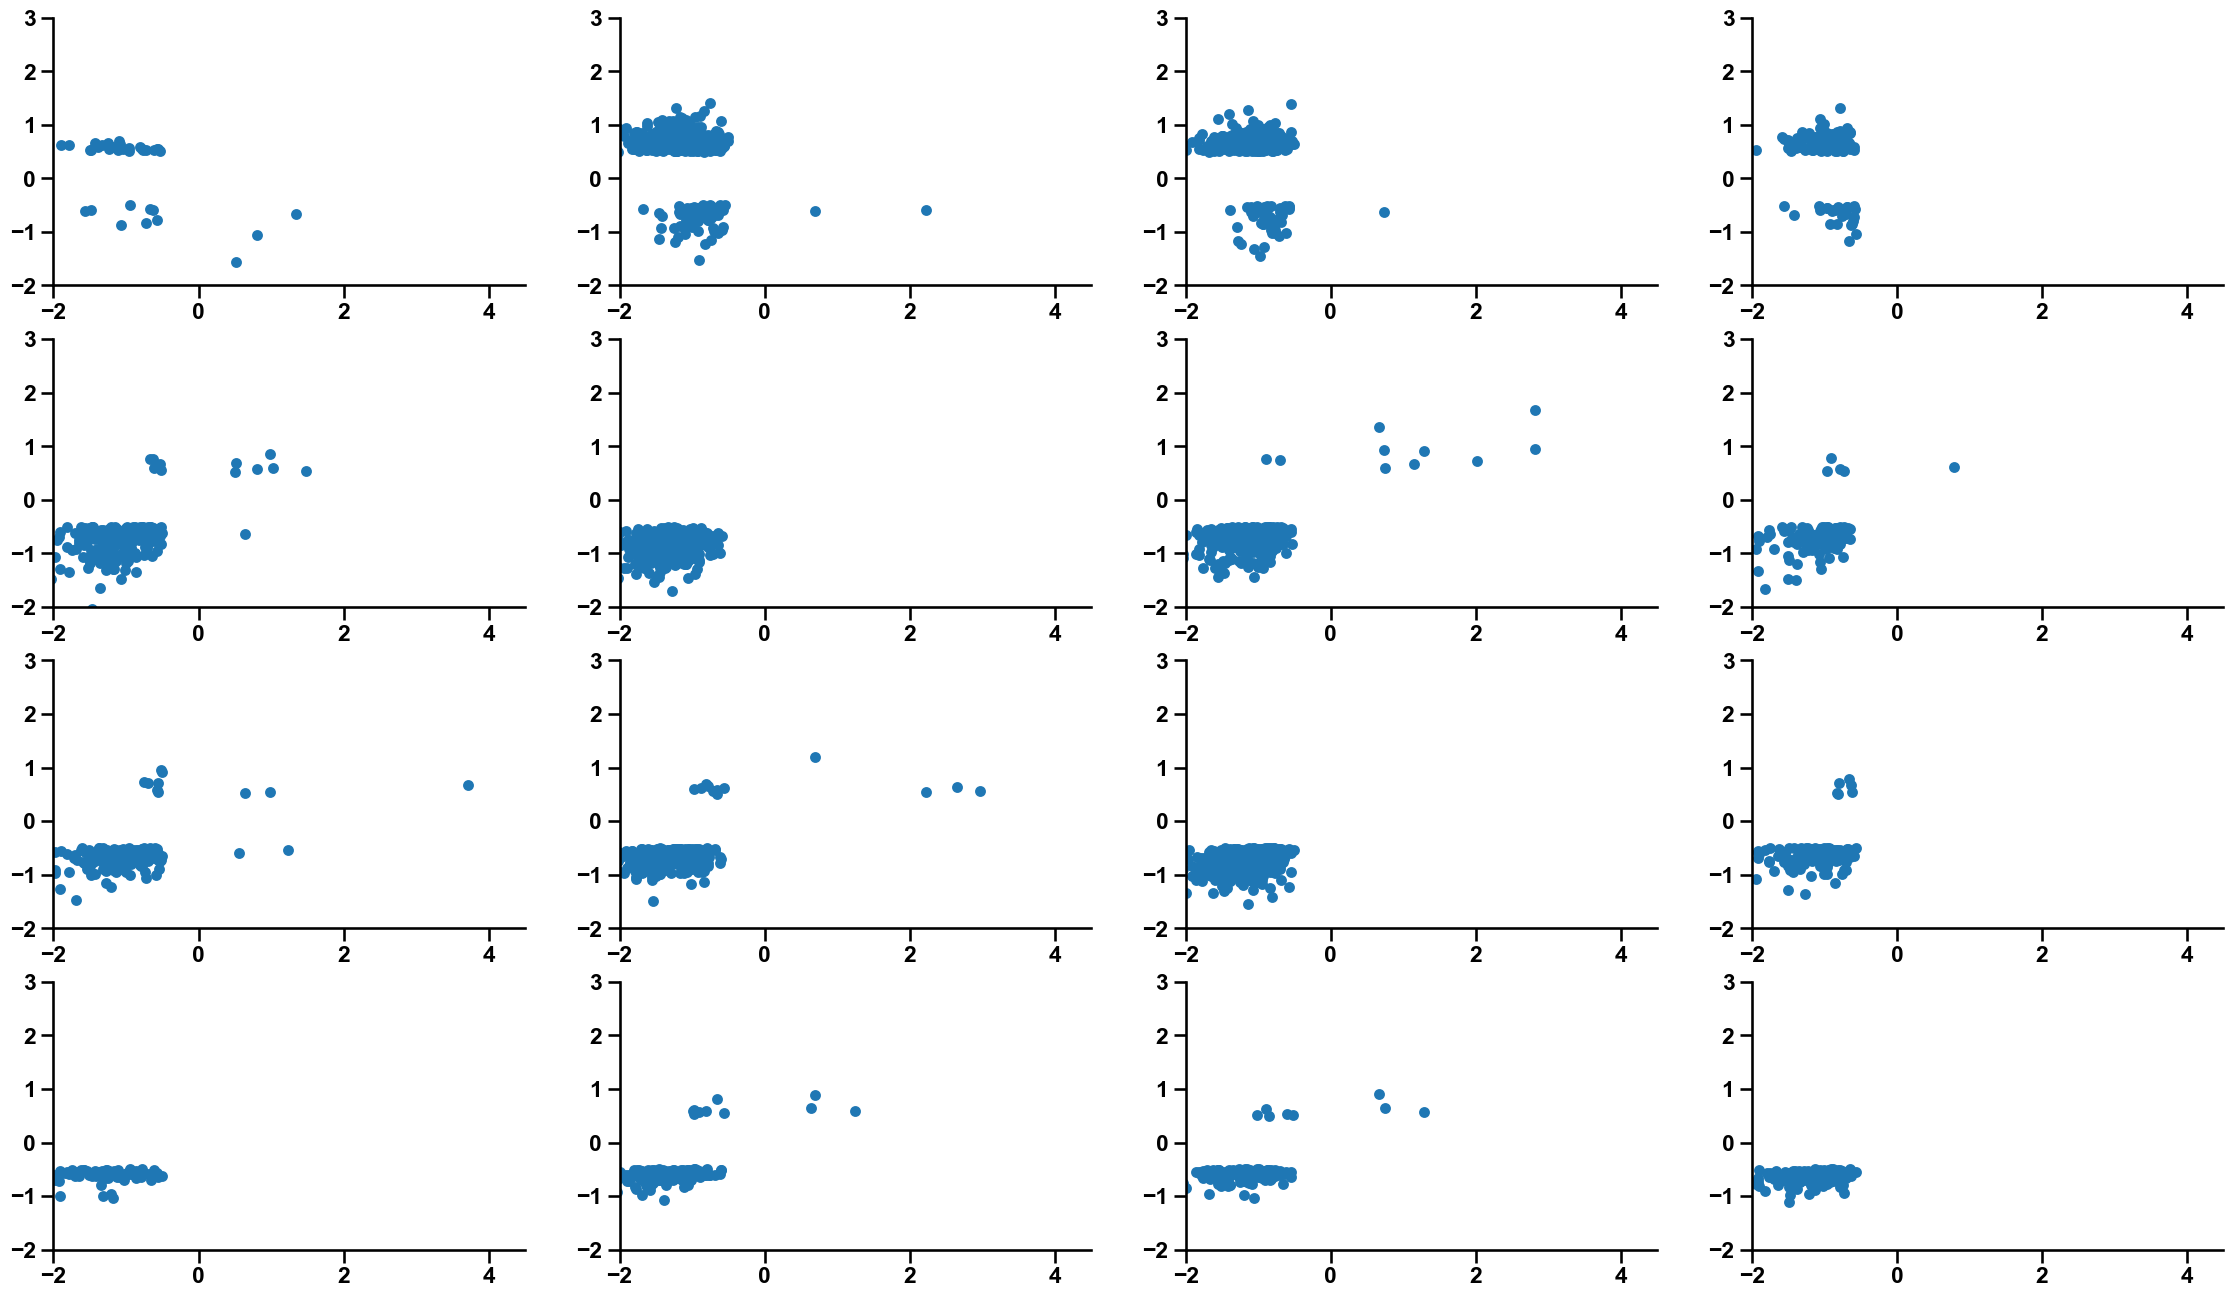

======> 9


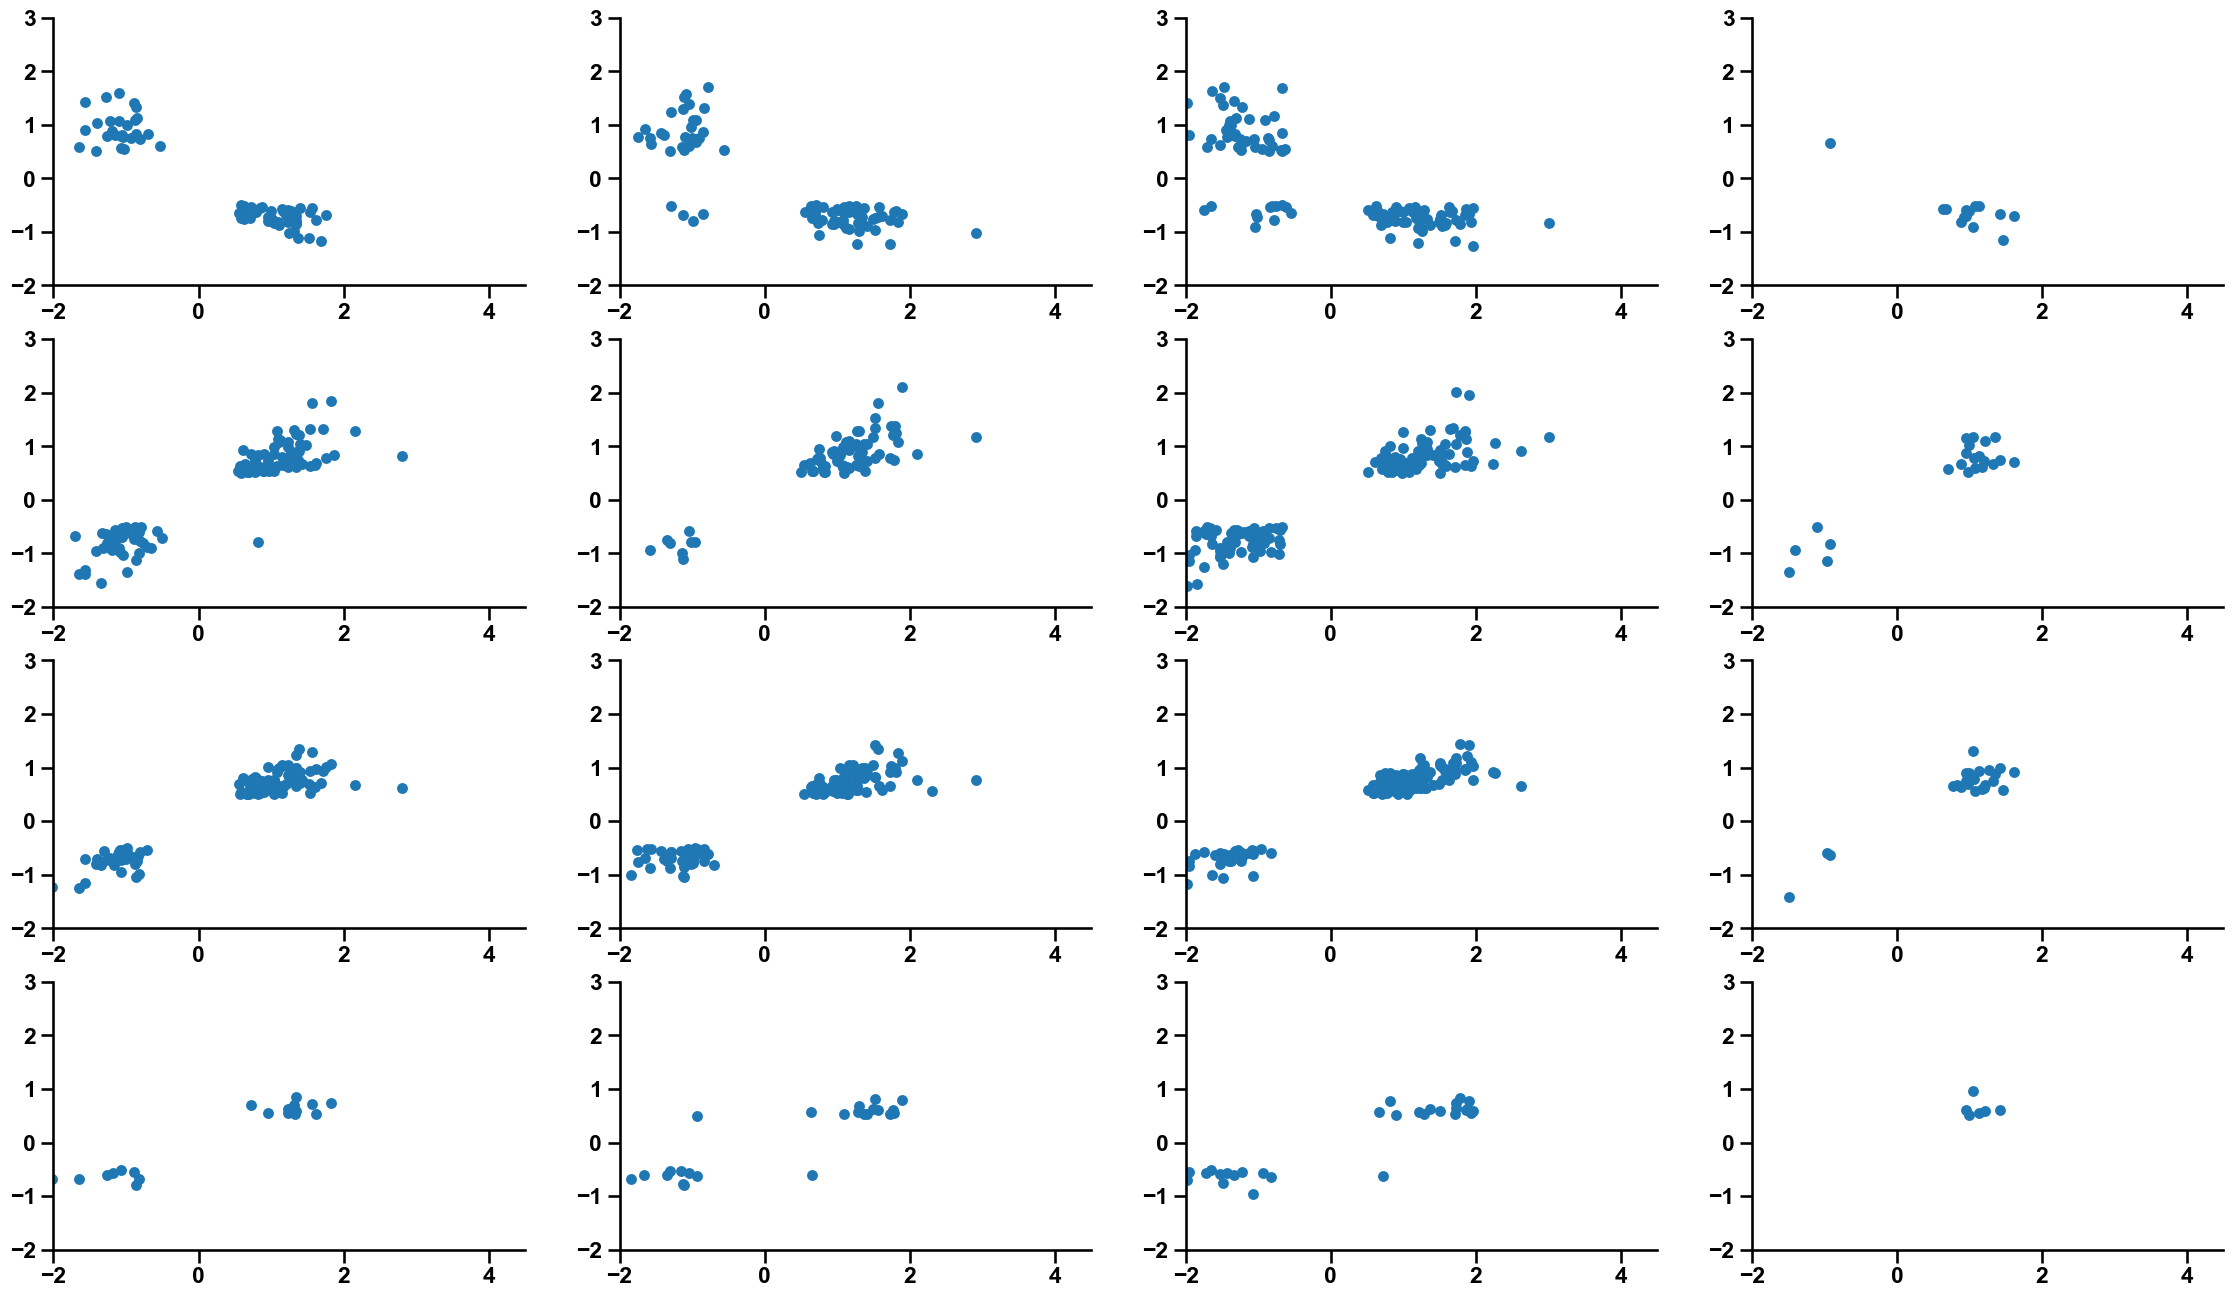

======> 10


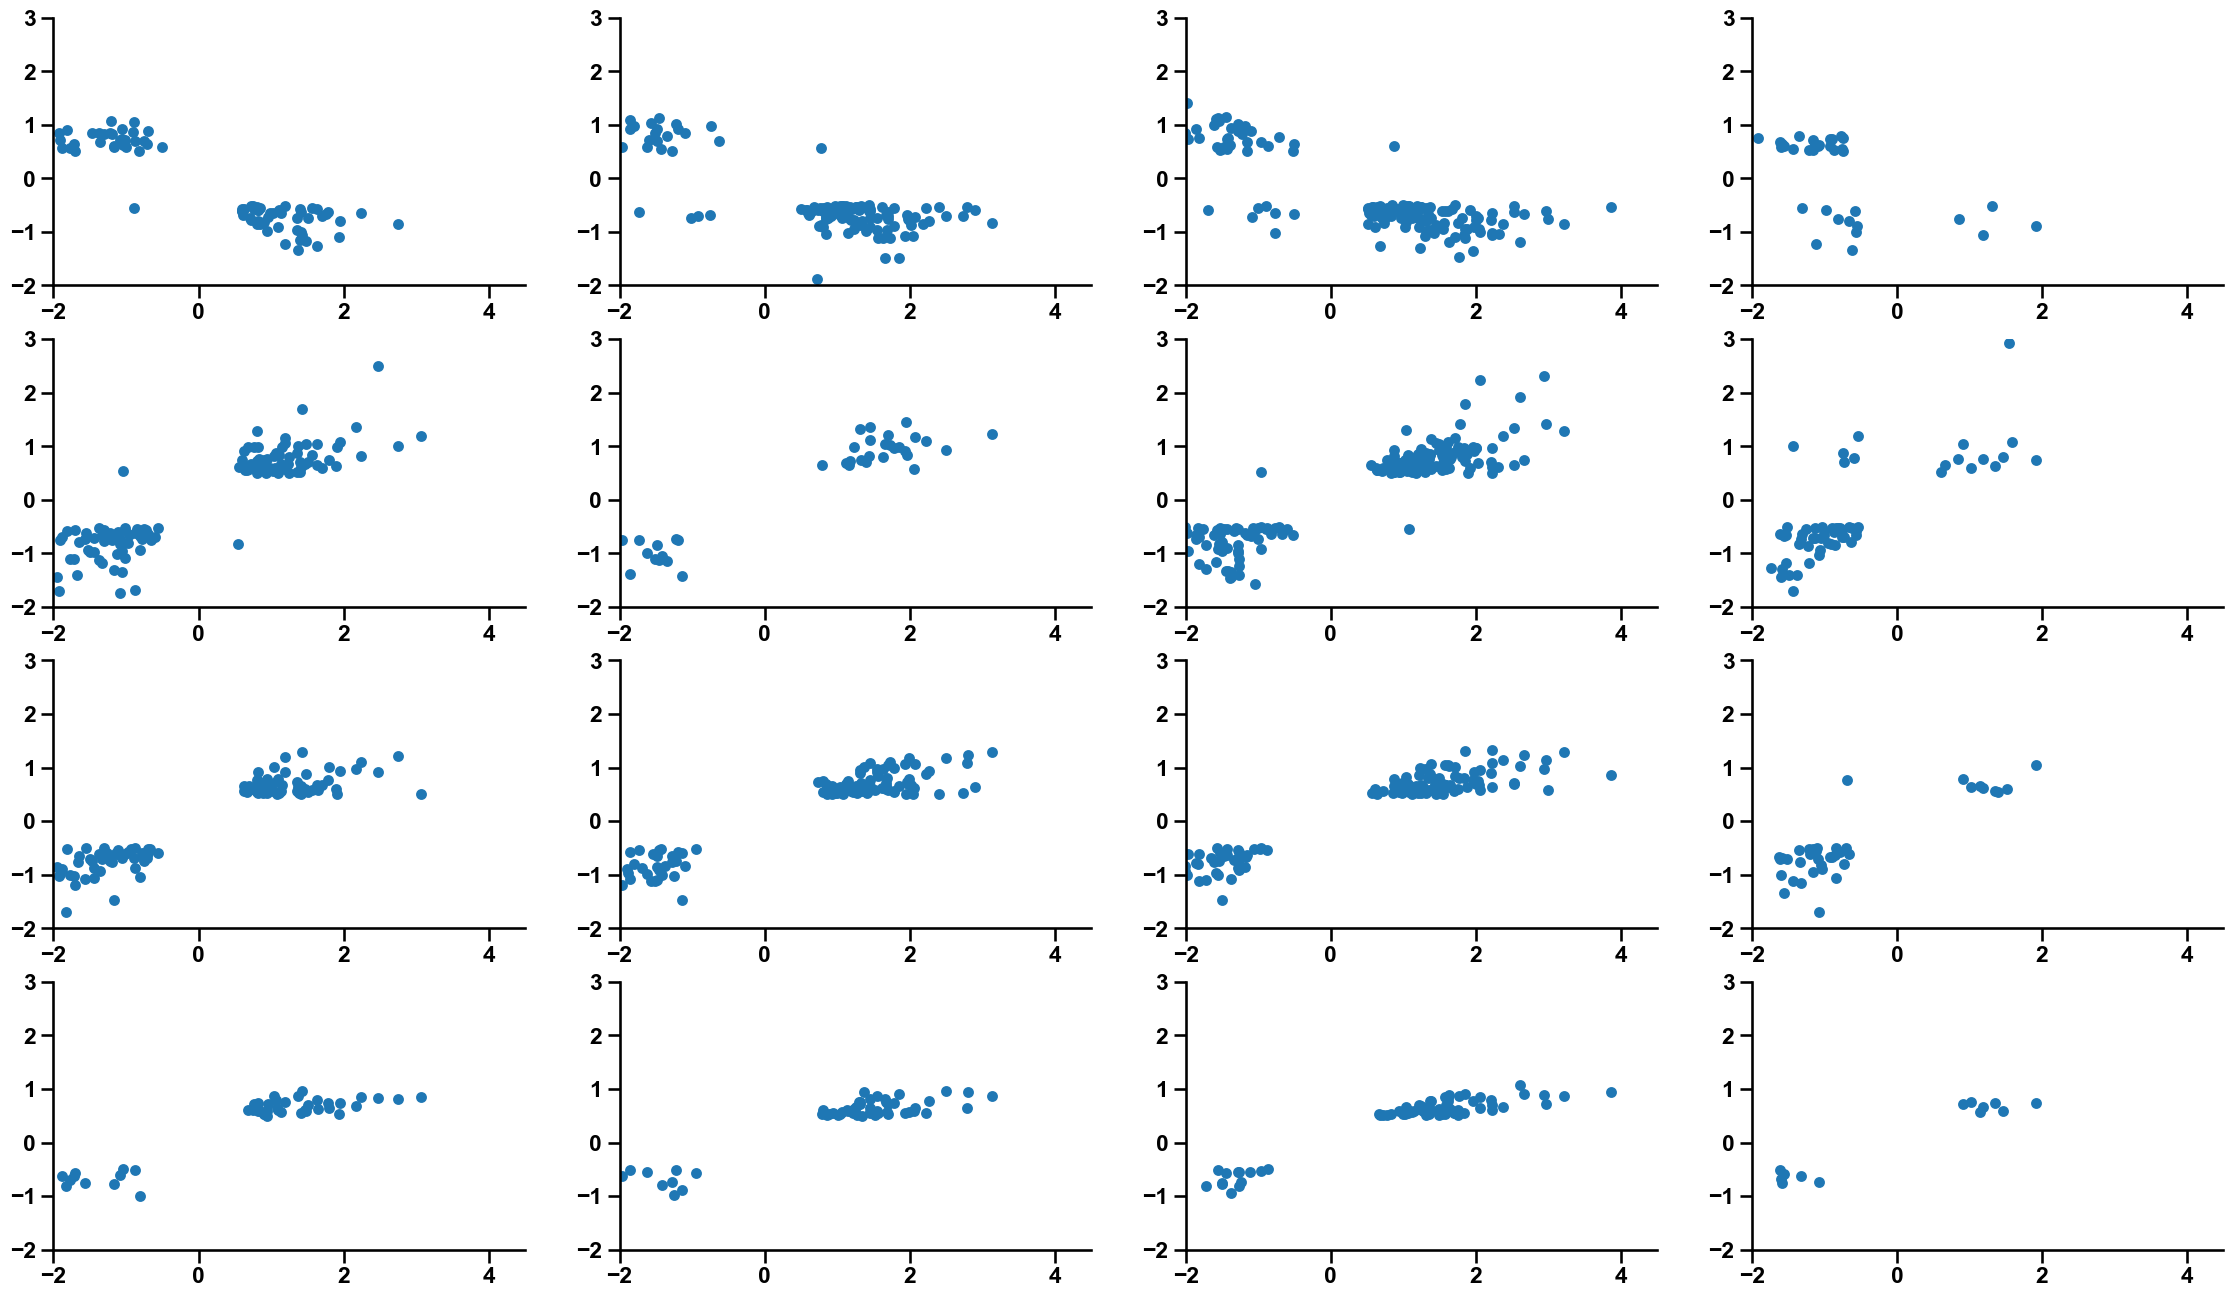

======> 11


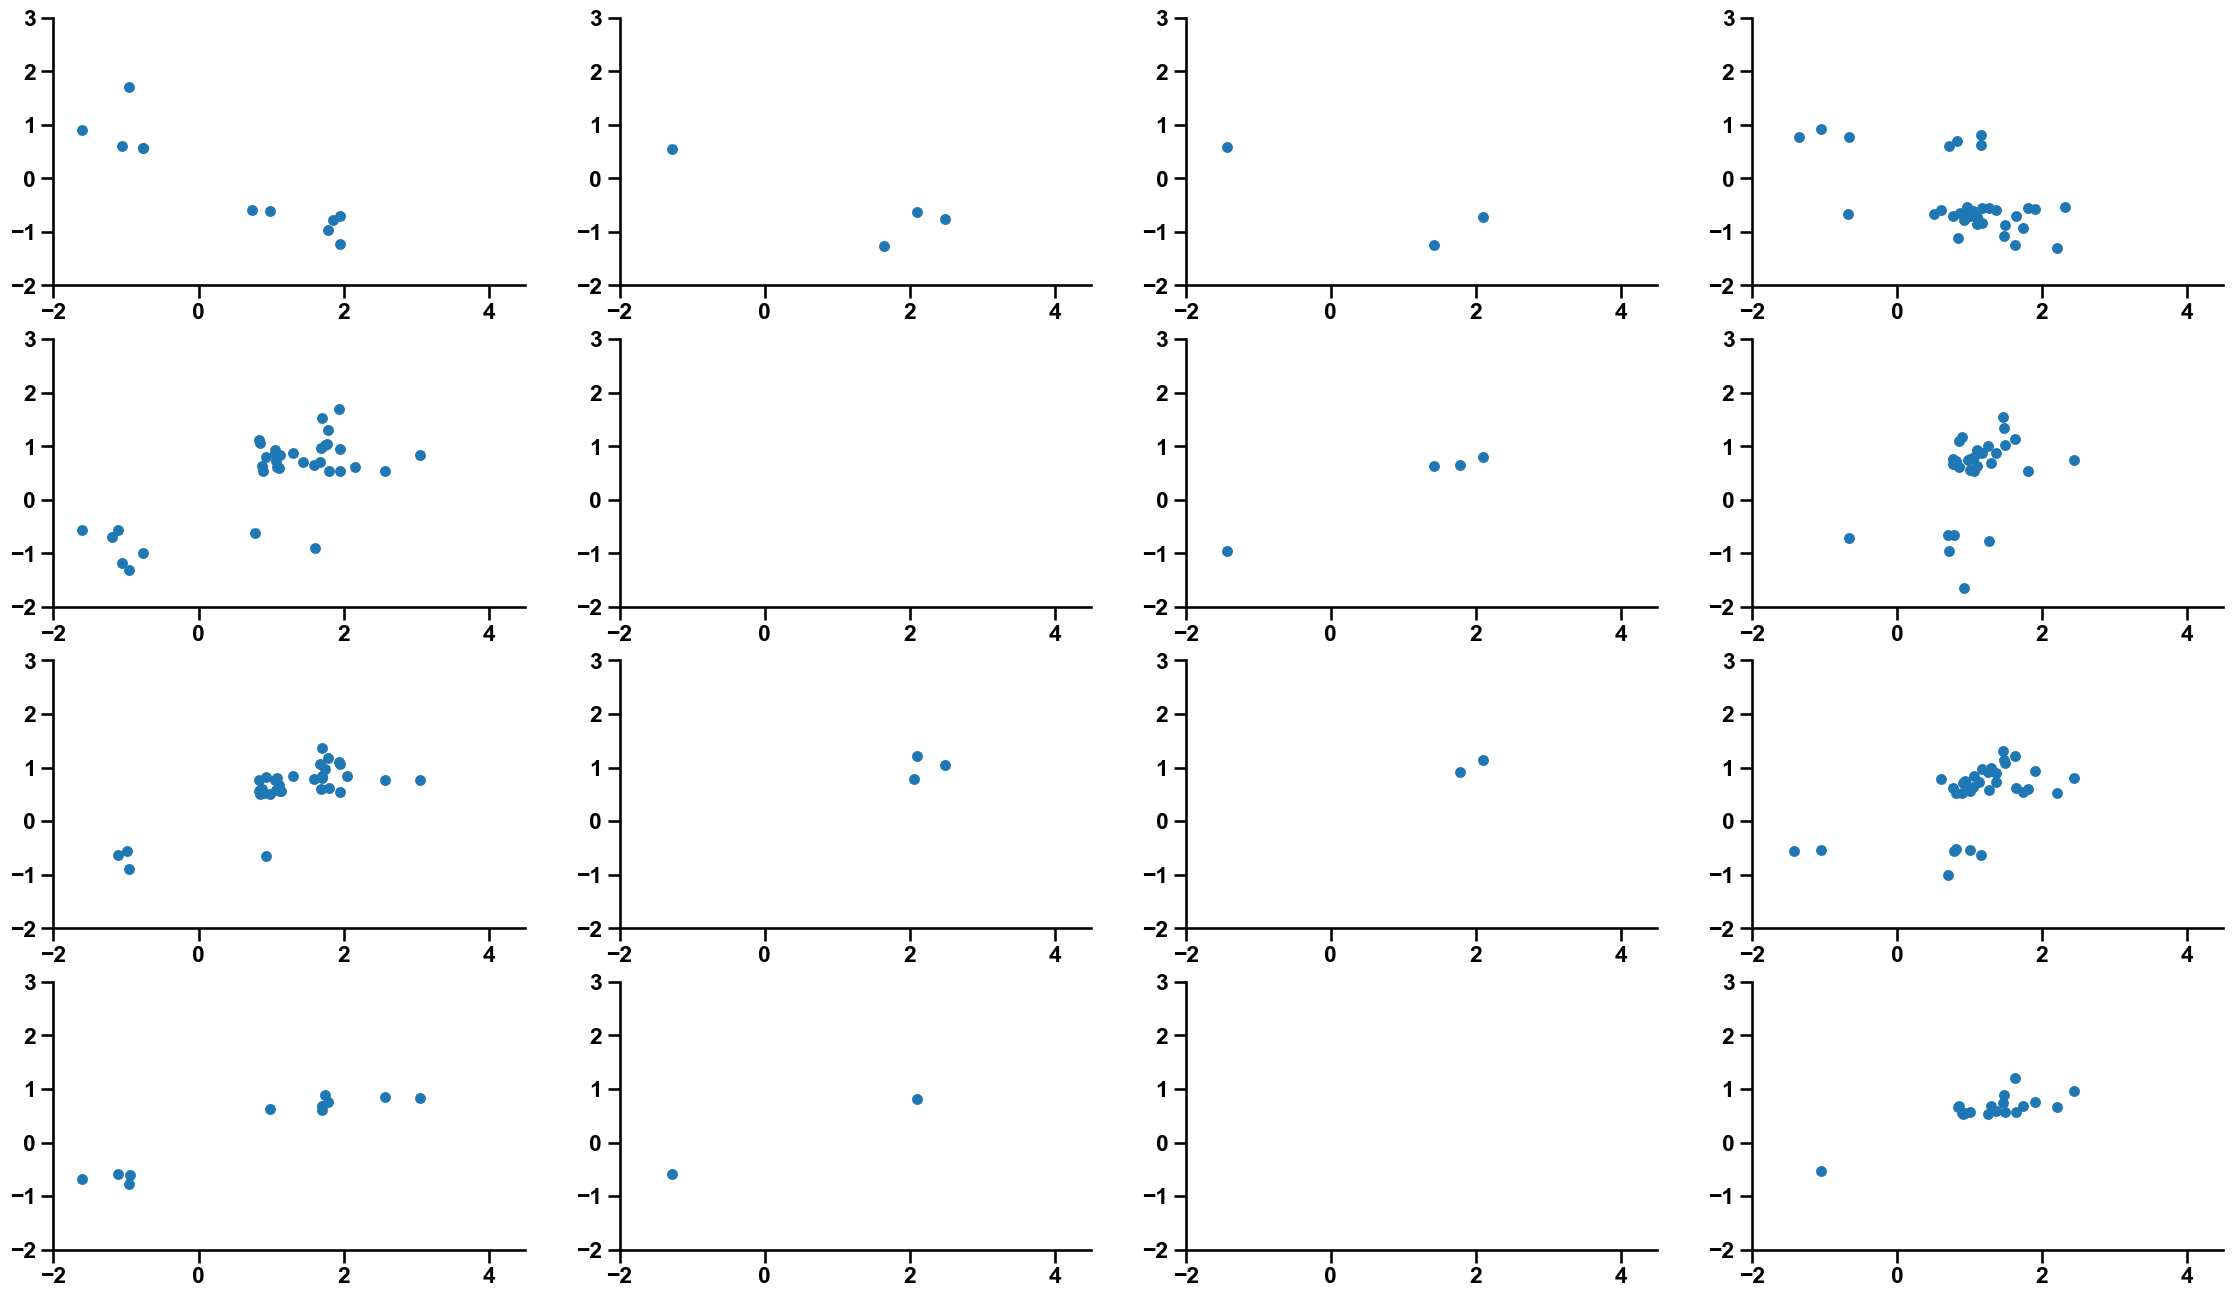

======> 12


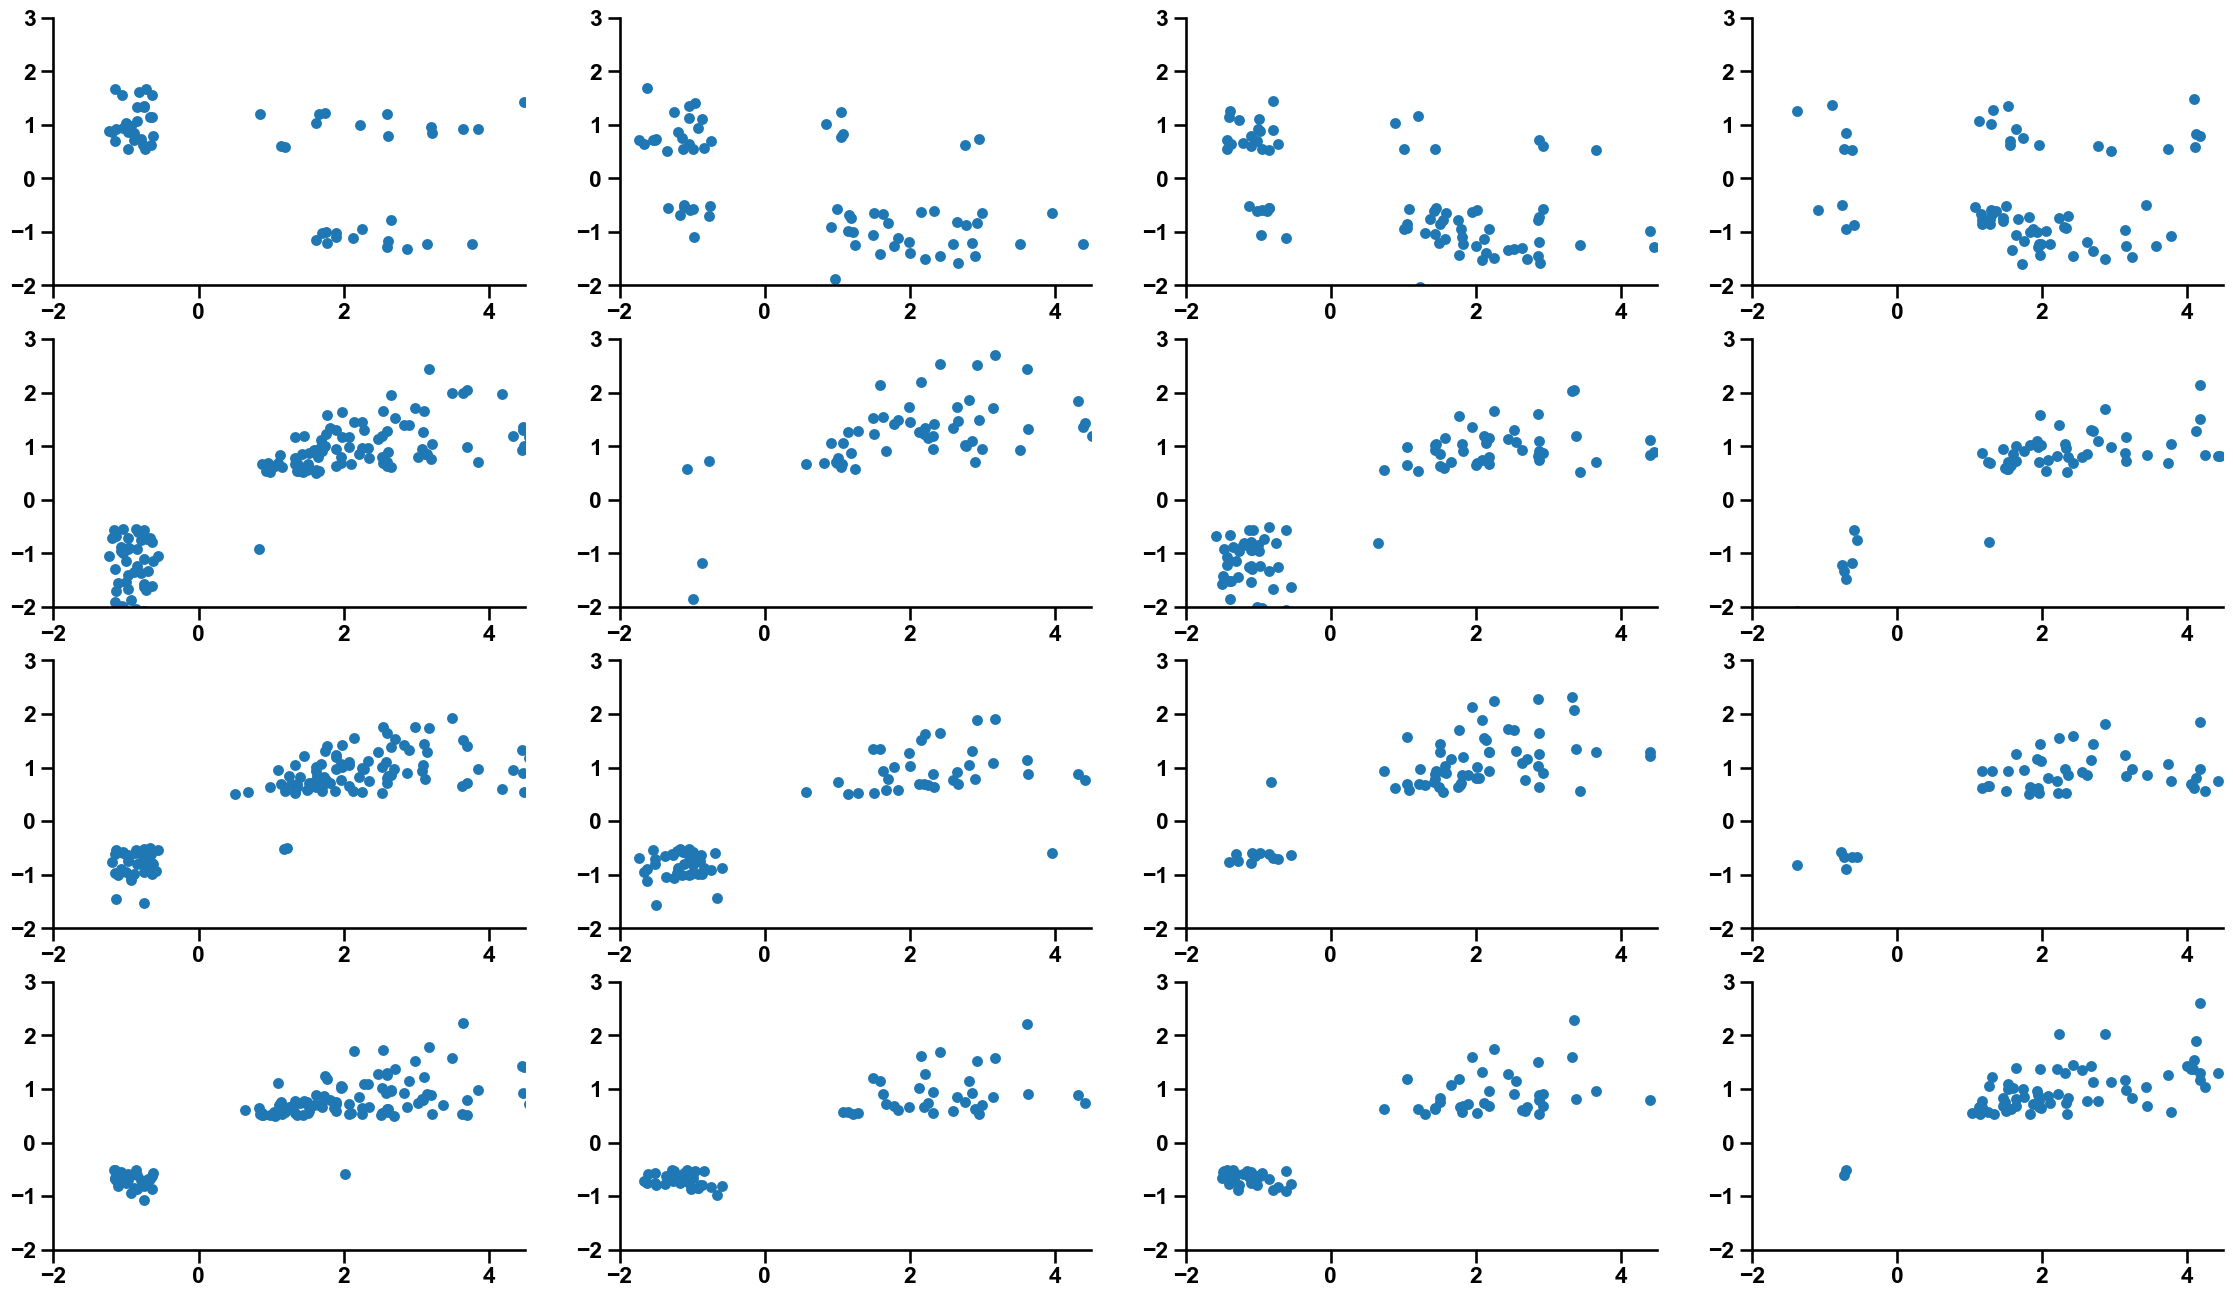

In [21]:
for clust in np.arange(1, 13, 1):
    clust = str(clust)
    adj_p_thr, logfc_cutoff = 1e-5, 0.5
    print('======>', clust)
    rna_list    = [get_clust_marker(ad, clust) for ad in rna_ads]
    k27me3_list = [get_clust_marker(ad, clust) for ad in h3k27me3_ads]
    k4me3_list  = [get_clust_marker(ad, clust) for ad in h3k4me3_ads]
    k27ac_list  = [get_clust_marker(ad, clust) for ad in h3k27ac_ads]
    atac_list   = [get_clust_marker(ad, clust) for ad in atac_ads]
    
    with plt.rc_context({'savefig.transparent': False, 
                         'font.size': 18, 'font.weight': 'bold', 'font.family': 'Arial'
        }):  
        _, axes = plt.subplots(4, 4, figsize=(7*4, 4*4))
        for ri, gs_list in enumerate([k27me3_list, k4me3_list, k27ac_list, atac_list]):
            for i, (d1, d2) in enumerate(zip(rna_list, gs_list)):
                _ = RNA_GS_relation_scatter(d1, d2, adj_pval_thr=adj_p_thr, logfc_cutoff=logfc_cutoff, ax=axes[ri][i])
                axes[ri][i].set_xlim(-2, 4.5)
                axes[ri][i].set_ylim(-2, 3)
        plt.show()

Upset plot of region-specific genes from a particular quandrant of measured and imputed relationships

In [22]:
# filtering threshold
adj_p_thr, logfc_cutoff = 1e-5, 0.5

# slice id, select from 1,2,3
# 3 indicating the last slice 
slice_id = 3  
# cluster id 
region = str(2)
# qudrant id
quadrant = 1

relation_title = ['h3k27me3', 'h3k4me3', 'h3k27ac', 'atac']

In [23]:
rna_list    = [get_clust_marker(ad, region) for ad in rna_ads]
k27me3_list = [get_clust_marker(ad, region) for ad in h3k27me3_ads]
k4me3_list  = [get_clust_marker(ad, region) for ad in h3k4me3_ads]
k27ac_list  = [get_clust_marker(ad, region) for ad in h3k27ac_ads]
atac_list   = [get_clust_marker(ad, region) for ad in atac_ads]

# x_qry1, y_qry1 = RNA_GS_relation_scatter(rna_list[slice_id], k27me3_list[slice_id], adj_pval_thr=adj_p_thr, logfc_cutoff=logfc_cutoff)
x_qry2, y_qry2 = RNA_GS_relation_scatter(rna_list[slice_id], k4me3_list[slice_id], adj_pval_thr=adj_p_thr, logfc_cutoff=logfc_cutoff, show=False)
x_qry3, y_qry3 = RNA_GS_relation_scatter(rna_list[slice_id], k27ac_list[slice_id], adj_pval_thr=adj_p_thr, logfc_cutoff=logfc_cutoff, show=False)
x_qry4, y_qry4 = RNA_GS_relation_scatter(rna_list[slice_id], atac_list[slice_id], adj_pval_thr=adj_p_thr, logfc_cutoff=logfc_cutoff, show=False)

relations = [(x_qry2, y_qry2), (x_qry3, y_qry3), (x_qry4, y_qry4)]

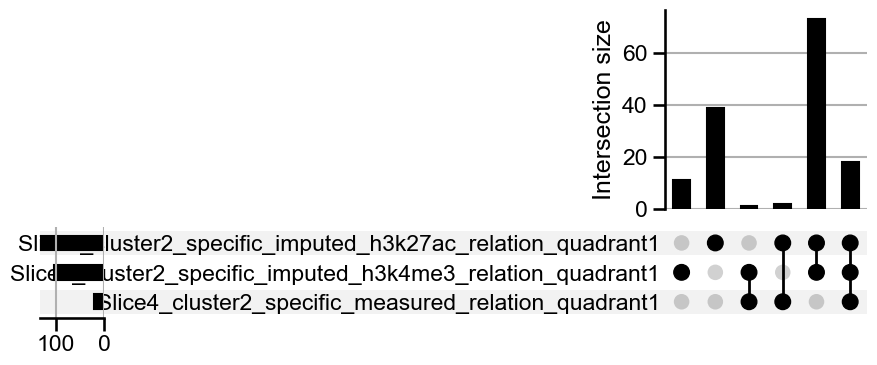

In [24]:
ref_gene = get_quadrant_genes(relations[slice_id-1][0], relations[slice_id-1][1], quadrant)
# qry_gene1 = get_quadrant_genes(x_qry1, y_qry1, quadrant)
qry_id_set = list(set([1,2,3]) - set([slice_id]))
qry_gene1 = get_quadrant_genes(relations[qry_id_set[0]-1][0], relations[qry_id_set[0]-1][1], quadrant)
qry_gene2 = get_quadrant_genes(relations[qry_id_set[1]-1][0], relations[qry_id_set[1]-1][1], quadrant)

ref_qry_upsetplot(ref_gene, [qry_gene1, qry_gene2], f'Slice{slice_id+1}_cluster{region}_specific_measured_relation_quadrant{quadrant}', 
                  [f'Slice{slice_id+1}_cluster{region}_specific_imputed_{relation_title[qry_id_set[0]]}_relation_quadrant{quadrant}', 
                   f'Slice{slice_id+1}_cluster{region}_specific_imputed_{relation_title[qry_id_set[1]]}_relation_quadrant{quadrant}'], 
                  # save_path=f'/path/to/figure.png'
)

Unique genes from the particular quadrant of the imputed relation

In [25]:
list_minus(qry_gene2, ref_gene)[:10]

['Clic4',
 'Dbndd2',
 'Josd2',
 'Clmn',
 'Rps17',
 'Ddr1',
 'Ppp2r3a',
 'Enpp2',
 'Rnf122',
 'Sirt2']

Spatial plot of measured and imputed gene scores

==> Measured RNA on the fourth slice


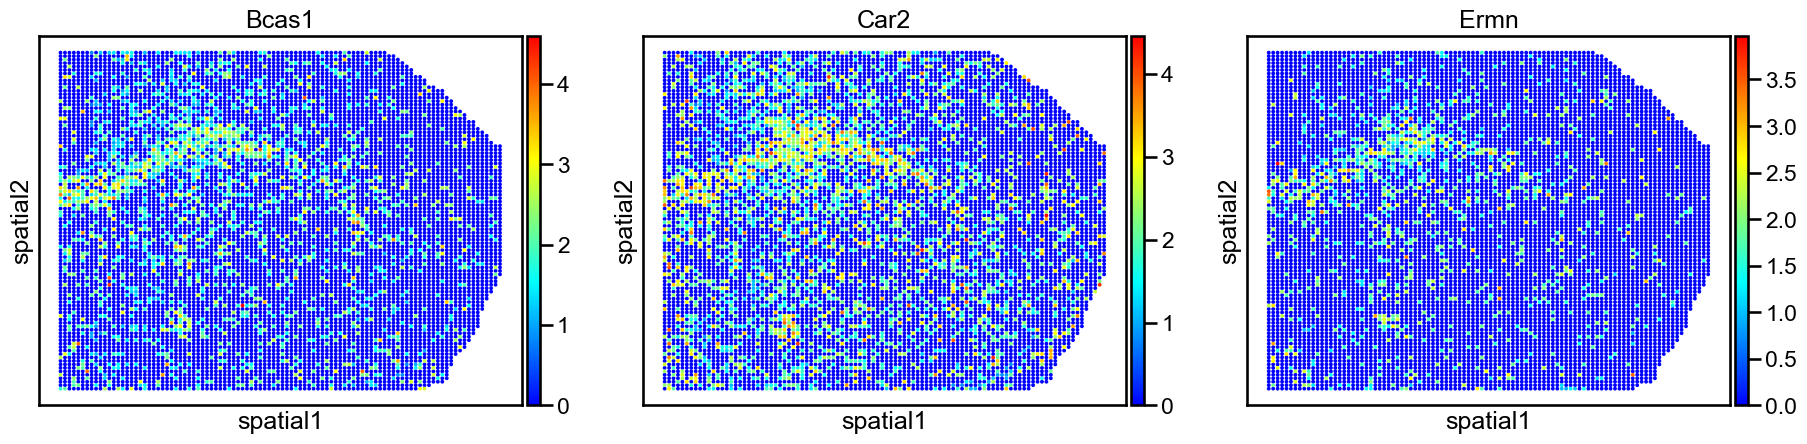

==> Measured ATAC GAS on the fourth slice


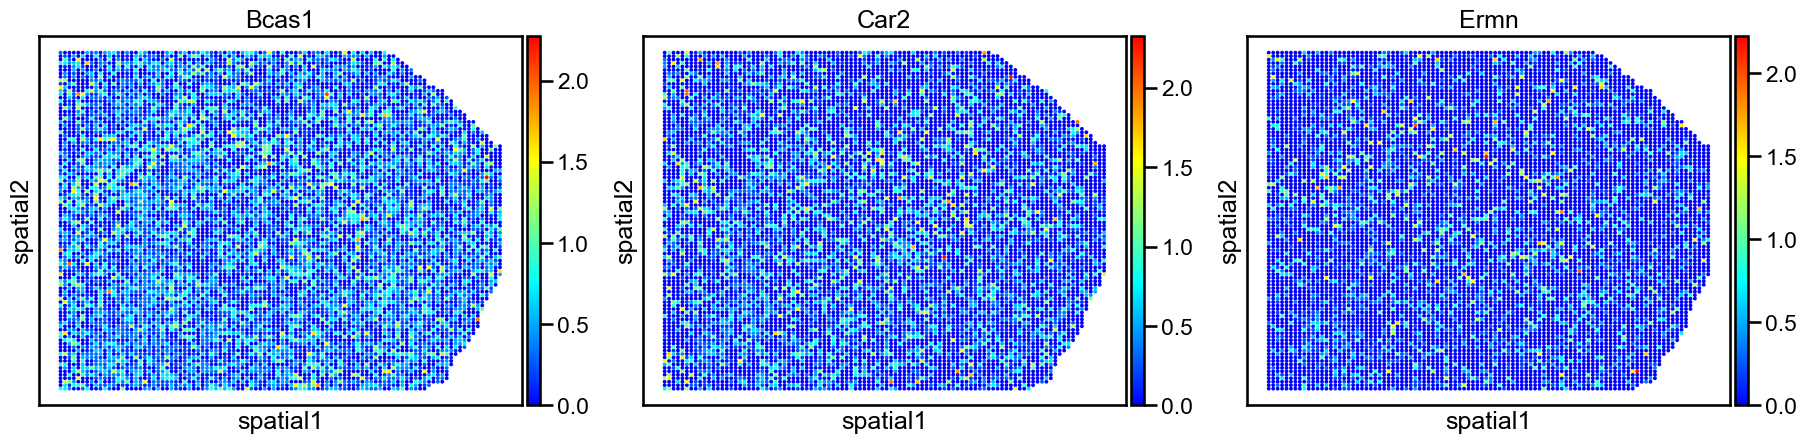

==> Imputed H3K4me3 GAS on the fourth slice


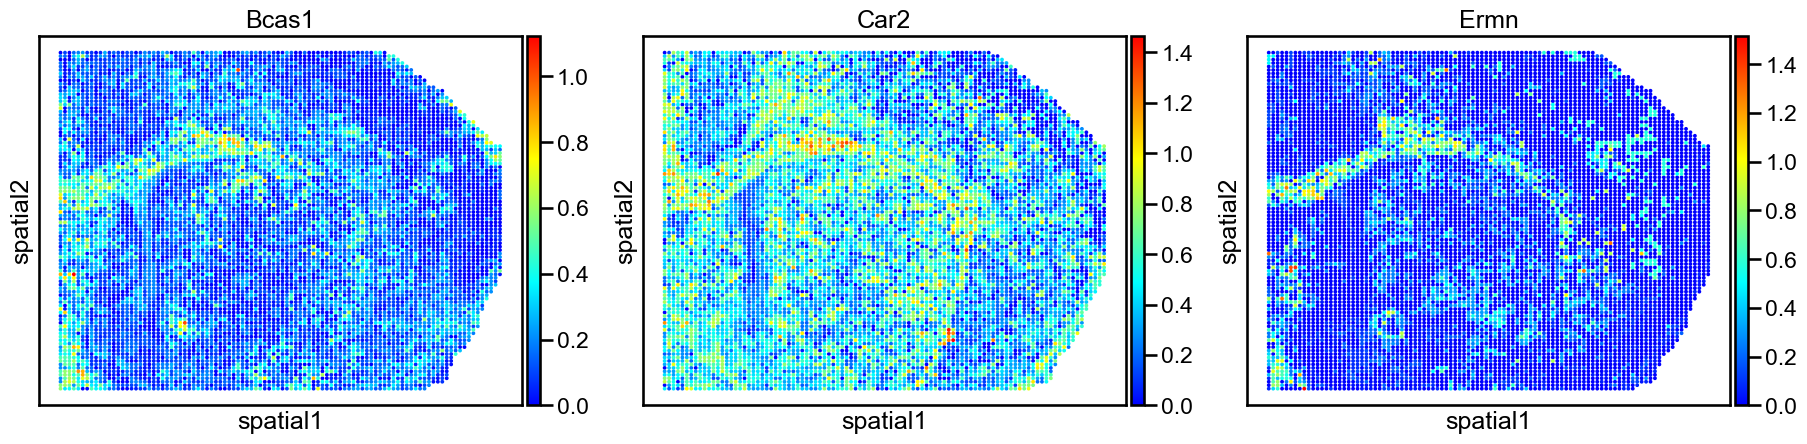

==> Imputed h3k27ac GAS on the fourth slice


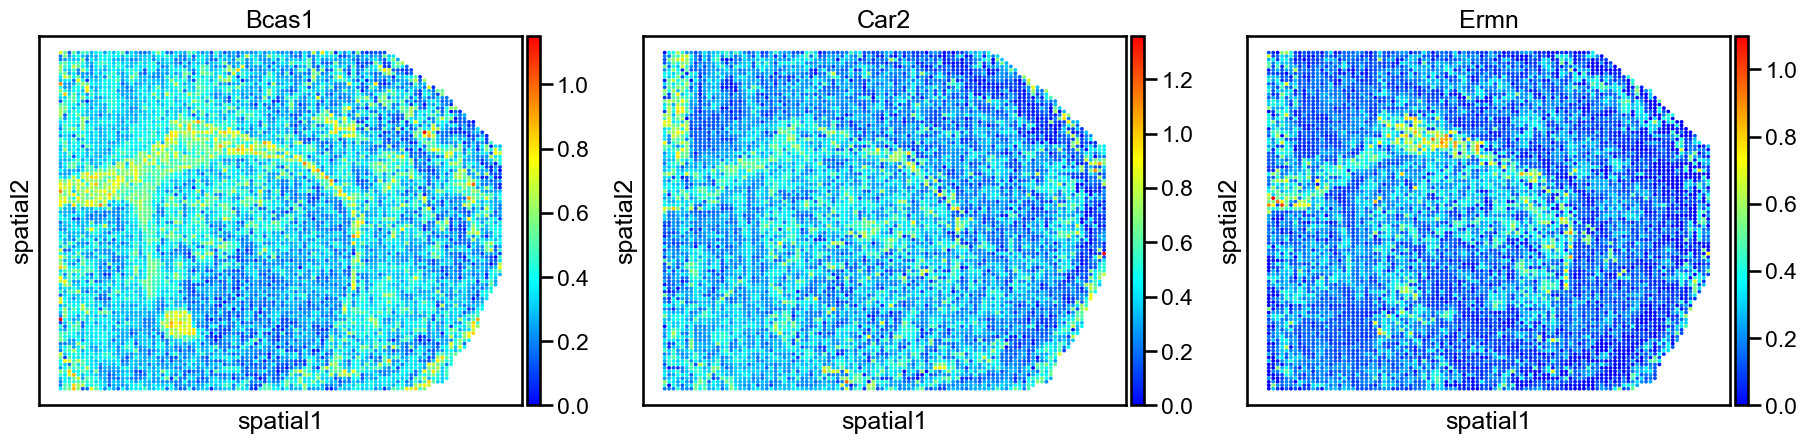

In [26]:
enhanced_genes = ['Bcas1', 'Car2', 'Ermn']

# dark_cmap = create_darkmap()
light_cmap = create_lightmap()

print('==> Measured RNA on the fourth slice')
utls.plot_basis(ad4_rna, 'spatial', enhanced_genes, s=30, cmap=light_cmap)
print('==> Measured ATAC GAS on the fourth slice')
utls.plot_basis(ad4_gs, 'spatial', enhanced_genes, s=30, cmap=light_cmap)
print('==> Imputed H3K4me3 GAS on the fourth slice')
utls.plot_basis(ad4_imp_h3k4me3_gs, 'spatial', enhanced_genes, s=30, cmap=light_cmap)
print('==> Imputed h3k27ac GAS on the fourth slice')
utls.plot_basis(ad4_imp_h3k27ac_gs, 'spatial', enhanced_genes, s=30, cmap=light_cmap)

Relation between measured ATAC and imputed histone modifications

In [27]:
imp_gs_on_slice4 = [ad4_imp_h3k27me3_gs, ad4_imp_h3k4me3_gs, ad4_imp_h3k27ac_gs]
histone_names = ['h3k27me3', 'k4me3', 'k27ac']

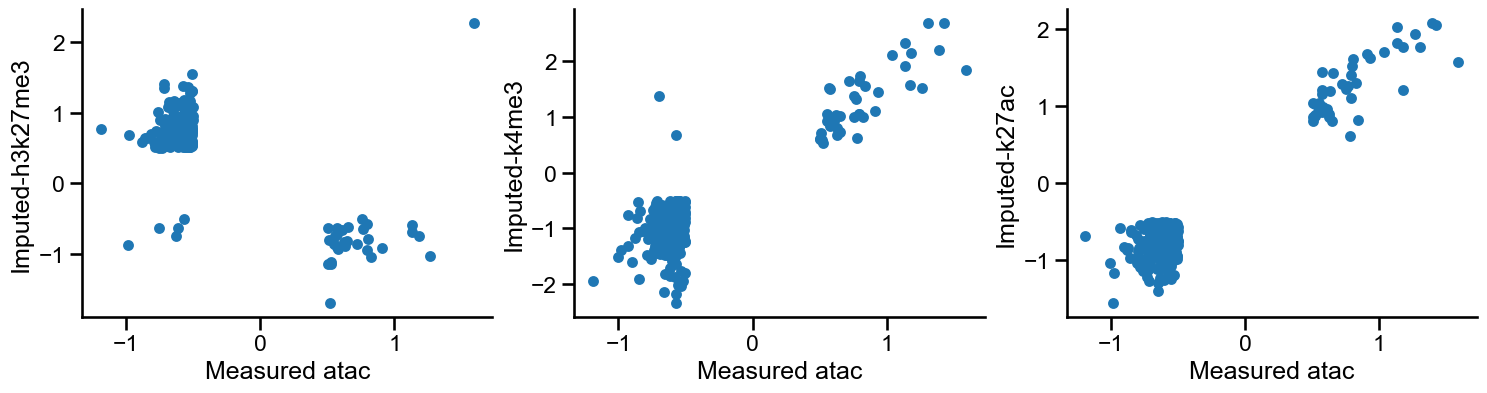

In [28]:
region = str(2)

quadrant_genes_list = []
_, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, ad_imp in enumerate(imp_gs_on_slice4):
    df_histone = get_clust_marker(ad_imp, region)
    df_atac    = get_clust_marker(ad4_gs, region)

    x, y = RNA_GS_relation_scatter(df_atac, df_histone, adj_pval_thr=1e-5, logfc_cutoff=.5, ax=axes[i])
    quadrant_genes_list.append(get_quadrant_genes(x, y, 4 if histone_names[i]=='h3k27me3' else 1))
    axes[i].set_ylabel('Imputed-'+histone_names[i])
    axes[i].set_xlabel('Measured atac')
plt.show()    

Genes from particular quadrant

In [29]:
# genes from quadrant 4 of H3K27me3-ATAC relation 
quadrant_genes_list[0] 
# genes from quadrant 1 of H3K4me3-ATAC relation 
quadrant_genes_list[1] 
# genes from quadrant 1 of H3K27ac-ATAC relation 
quadrant_genes_list[2] 

Index(['Gm10863', 'Mobp', 'Pacrg', 'Rnf220', 'Qk', 'Tns3', 'Chd7',
       'A230009B12Rik', 'Sox10', 'Gab1', 'Plp1', 'Zcchc24', 'Sox2ot', 'Zeb2',
       'Cldn11', 'Olig1', 'Mal', 'Wscd1', 'Mir219a-2', 'Tfeb', 'Fa2h',
       'Zeb2os', 'Fgfr2', 'Urm1', 'Phldb1', 'Tspan2', 'Mag', 'Micall1',
       'Kcnj10', 'Ick', 'Ugt8a', 'Gpr17', 'Olig2', 'Lims2', 'Cdc42ep1',
       'Nkx2-2os', 'Mir219b', 'Mir5129', 'Sox2', 'Cnp', 'Dnajc7', 'Plekhg3'],
      dtype='object')